In [1]:
import numpy as np
import pandas as pd

def Ackley(x1, x2):
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1**2 + x2**2)))
    term2 = -np.exp(0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2)))
    return term1 + term2 + np.e + 20

def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    z = Ackley(x1, x2)
    return x1, x2, z

def create_dataframe(grid):
   x1, x2, z = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_46454/2610556376.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


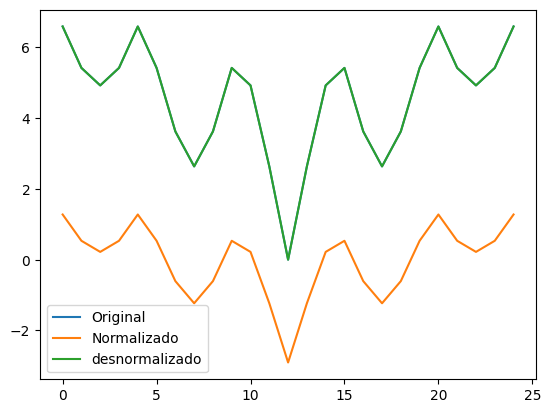

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [4]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 2.36 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [5]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [6]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-14 12:38:52.515374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 12:38:52.515427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 12:38:52.516722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 12:38:52.533874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 12:38:55.870026: W tensorflow/compiler/tf2

In [7]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [8]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [9]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 28ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.909343,-0.048479,-1.366607,0.868401,0.220056,2.101875,1.745167,0.096006,1.296868e+14,0.469101,0.876553,0.476489,37.027746,73.992329
model_1_7_1,0.910482,-0.050939,-1.371413,0.868818,0.217292,2.106807,1.748711,0.095702,1.290313e+14,0.466146,0.878103,0.473487,37.053026,74.017609
model_1_7_2,0.911598,-0.053393,-1.376217,0.869222,0.214582,2.111727,1.752253,0.095408,1.283822e+14,0.463230,0.879623,0.470526,37.078122,74.042706
model_1_7_3,0.912693,-0.055841,-1.381014,0.869611,0.211927,2.116633,1.755791,0.095124,1.277393e+14,0.460355,0.881113,0.467605,37.103031,74.067615
model_1_7_4,0.913765,-0.058282,-1.385811,0.869989,0.209323,2.121528,1.759328,0.094848,1.271028e+14,0.457518,0.882574,0.464724,37.127755,74.092338
model_1_7_5,0.914816,-0.060716,-1.390593,0.870352,0.206771,2.126405,1.762854,0.094584,1.264724e+14,0.454721,0.884005,0.461883,37.152283,74.116867
model_1_7_6,0.915847,-0.063141,-1.395370,0.870703,0.204270,2.131267,1.766377,0.094327,1.258483e+14,0.451963,0.885408,0.459081,37.176622,74.141205
model_1_7_7,0.916856,-0.065557,-1.400131,0.871040,0.201819,2.136111,1.769887,0.094081,1.252302e+14,0.449243,0.886783,0.456318,37.200765,74.165349
model_1_7_8,0.917846,-0.067964,-1.404888,0.871368,0.199417,2.140937,1.773396,0.093842,1.246185e+14,0.446561,0.888131,0.453594,37.224714,74.189297
model_1_7_9,0.918816,-0.070362,-1.409630,0.871683,0.197063,2.145743,1.776892,0.093612,1.240129e+14,0.443918,0.889451,0.450909,37.248463,74.213046


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  67
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_8] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.956284,-0.242881,-1.706991,0.959791,0.106114,2.491591,1.996170,0.072020,9.286563e+13,0.325751,0.940472,0.330882,38.486484,75.451067
model_1_8_1,0.956558,-0.245285,-1.711312,0.959560,0.105450,2.496409,1.999357,0.072433,9.249267e+13,0.324731,0.940844,0.329846,38.499028,75.463612
model_1_8_2,0.956824,-0.247670,-1.715604,0.959324,0.104804,2.501192,2.002522,0.072856,9.212333e+13,0.323734,0.941207,0.328832,38.511336,75.475920
model_1_8_3,0.957084,-0.250038,-1.719865,0.959082,0.104173,2.505938,2.005663,0.073288,9.175758e+13,0.322758,0.941561,0.327841,38.523408,75.487992
model_1_8_4,0.957337,-0.252387,-1.724095,0.958836,0.103558,2.510648,2.008783,0.073730,9.139545e+13,0.321804,0.941906,0.326872,38.535249,75.499833
model_1_8_5,0.957584,-0.254719,-1.728299,0.958584,0.102958,2.515322,2.011883,0.074181,9.103685e+13,0.320871,0.942242,0.325925,38.546861,75.511445
model_1_8_6,0.957825,-0.257032,-1.732473,0.958327,0.102374,2.519960,2.014961,0.074641,9.068174e+13,0.319959,0.942570,0.324998,38.558245,75.522828
model_1_8_7,0.958060,-0.259328,-1.736617,0.958066,0.101805,2.524561,2.018017,0.075109,9.033020e+13,0.319068,0.942890,0.324093,38.569400,75.533984
model_1_8_8,0.958288,-0.261605,-1.740732,0.957800,0.101250,2.529126,2.021051,0.075585,8.998206e+13,0.318197,0.943201,0.323209,38.580332,75.544916
model_1_8_9,0.958511,-0.263863,-1.744817,0.957530,0.100709,2.533653,2.024064,0.076068,8.963745e+13,0.317347,0.943504,0.322345,38.591041,75.555625


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_9] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.959770,-0.273932,-1.761549,0.957742,0.097654,2.553838,2.036402,0.107711,8.806094e+13,0.312496,0.945218,0.317418,38.652654,75.617238
model_1_9_1,0.959936,-0.275369,-1.764052,0.957742,0.097251,2.556720,2.038247,0.107711,8.784065e+13,0.311850,0.945444,0.316762,38.660929,75.625513
model_1_9_2,0.960098,-0.276801,-1.766567,0.957740,0.096856,2.559590,2.040103,0.107716,8.762193e+13,0.311216,0.945666,0.316118,38.669066,75.633650
model_1_9_3,0.960258,-0.278226,-1.769089,0.957736,0.096469,2.562446,2.041962,0.107726,8.740498e+13,0.310595,0.945883,0.315487,38.677062,75.641646
model_1_9_4,0.960413,-0.279642,-1.771618,0.957730,0.096091,2.565286,2.043827,0.107741,8.718975e+13,0.309985,0.946095,0.314867,38.684920,75.649503
model_1_9_5,0.960566,-0.281051,-1.774156,0.957722,0.095721,2.568109,2.045698,0.107760,8.697628e+13,0.309388,0.946302,0.314260,38.692639,75.657223
model_1_9_6,0.960715,-0.282449,-1.776691,0.957713,0.095359,2.570912,2.047568,0.107784,8.676483e+13,0.308802,0.946506,0.313666,38.700216,75.664800
model_1_9_7,0.960861,-0.283838,-1.779225,0.957701,0.095005,2.573696,2.049436,0.107813,8.655525e+13,0.308229,0.946704,0.313083,38.707652,75.672236
model_1_9_8,0.961003,-0.285215,-1.781755,0.957688,0.094659,2.576457,2.051302,0.107847,8.634761e+13,0.307667,0.946898,0.312512,38.714951,75.679534
model_1_9_9,0.961143,-0.286582,-1.784283,0.957673,0.094321,2.579197,2.053166,0.107885,8.614188e+13,0.307117,0.947088,0.311953,38.722110,75.686693


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_10] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_6,0.961643,-0.246682,-1.718465,0.958620,0.093107,2.499210,2.004631,0.081892,8.690021e+13,0.305135,0.947769,0.309940,38.748009,75.712593
model_1_10_8,0.962397,-0.248124,-1.725528,0.958510,0.091276,2.502101,2.009840,0.082109,8.565239e+13,0.302118,0.948796,0.306876,38.787745,75.752328
model_1_10_7,0.962112,-0.248569,-1.724919,0.958601,0.091969,2.502994,2.009391,0.081929,8.616005e+13,0.303263,0.948407,0.308039,38.772616,75.737199
model_1_10_5,0.961387,-0.250739,-1.723984,0.958696,0.093729,2.507343,2.008701,0.081742,8.720133e+13,0.306152,0.947420,0.310973,38.734700,75.699283
model_1_10_9,0.962815,-0.251396,-1.734000,0.958461,0.090262,2.508661,2.016087,0.082206,8.488276e+13,0.300437,0.949365,0.305168,38.810072,75.774656
model_1_10_4,0.961387,-0.262816,-1.746040,0.958785,0.093727,2.531555,2.024965,0.081565,8.688834e+13,0.306149,0.947421,0.310971,38.734730,75.699314
model_1_10_3,0.961216,-0.275410,-1.766424,0.958714,0.094142,2.556801,2.039997,0.081705,8.658690e+13,0.306825,0.947188,0.311657,38.725910,75.690493
model_1_10_2,0.961216,-0.278457,-1.771488,0.958712,0.094143,2.562910,2.043731,0.081708,8.645320e+13,0.306828,0.947187,0.311660,38.725872,75.690456
model_1_10_1,0.961203,-0.281341,-1.776160,0.958706,0.094174,2.568691,2.047177,0.081721,8.633403e+13,0.306878,0.947170,0.311711,38.725214,75.689798
model_1_10_0,0.961176,-0.283961,-1.780251,0.958695,0.094241,2.573943,2.050193,0.081742,8.623731e+13,0.306986,0.947133,0.311821,38.723809,75.688393


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_11] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.963289,-0.257116,-1.747636,0.976747,0.089111,2.520128,2.026143,0.059955,8.394353e+13,0.298514,0.950011,0.303215,38.835751,75.800335
model_1_11_1,0.963716,-0.264866,-1.765737,0.976136,0.088075,2.535664,2.039491,0.061531,8.286140e+13,0.296774,0.950592,0.301448,38.859134,75.823718
model_1_11_3,0.963844,-0.266823,-1.772199,0.975169,0.087763,2.539586,2.044255,0.064024,8.220420e+13,0.296248,0.950767,0.300914,38.866233,75.830817
model_1_11_2,0.963875,-0.267611,-1.773466,0.975326,0.087687,2.541167,2.045190,0.063618,8.219964e+13,0.296120,0.950809,0.300784,38.867959,75.832542
model_1_11_4,0.964045,-0.271665,-1.784676,0.974367,0.087276,2.549294,2.053456,0.066092,8.141457e+13,0.295426,0.951040,0.300078,38.877354,75.841938
model_1_11_5,0.964234,-0.277215,-1.798833,0.973543,0.086817,2.560419,2.063896,0.068216,8.059932e+13,0.294648,0.951297,0.299288,38.887899,75.852483
model_1_11_7,0.964288,-0.280634,-1.808796,0.972475,0.086685,2.567274,2.071242,0.070971,7.993025e+13,0.294423,0.951372,0.299060,38.890955,75.855538
model_1_11_6,0.964313,-0.280784,-1.809035,0.972636,0.086625,2.567575,2.071419,0.070553,7.995954e+13,0.294321,0.951405,0.298956,38.892339,75.856923
model_1_11_8,0.964281,-0.282665,-1.815969,0.971503,0.086704,2.571346,2.076532,0.073477,7.943378e+13,0.294455,0.951361,0.299092,38.890517,75.855101
model_1_11_9,0.964263,-0.282785,-1.816397,0.971344,0.086746,2.571586,2.076848,0.073887,7.938659e+13,0.294526,0.951337,0.299165,38.889546,75.854130


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_7,0.961951,-0.243435,-1.737668,0.942184,0.092359,2.492702,2.018792,0.228662,9.007926e+13,0.303907,0.948188,0.308693,38.764136,75.728720
model_1_12_8,0.961775,-0.243819,-1.739964,0.940848,0.092786,2.493472,2.020485,0.233946,9.078191e+13,0.304608,0.947949,0.309405,38.754922,75.719506
model_1_12_9,0.961651,-0.245817,-1.746053,0.939530,0.093087,2.497477,2.024975,0.239159,9.139504e+13,0.305101,0.947780,0.309906,38.748444,75.713027
model_1_12_5,0.962631,-0.247234,-1.743374,0.947075,0.090707,2.500318,2.022999,0.209318,8.714239e+13,0.301177,0.949115,0.305920,38.800231,75.764814
model_1_12_6,0.962539,-0.249665,-1.750282,0.944578,0.090931,2.505191,2.028094,0.219195,8.860328e+13,0.301547,0.948990,0.306296,38.795312,75.759896
model_1_12_4,0.963274,-0.257212,-1.763841,0.949420,0.089148,2.520320,2.038092,0.200045,8.534620e+13,0.298577,0.949990,0.303279,38.834911,75.799495
model_1_12_3,0.963323,-0.258066,-1.765400,0.951035,0.089027,2.522031,2.039242,0.193655,8.420498e+13,0.298374,0.950058,0.303073,38.837629,75.802213
model_1_12_2,0.963990,-0.272150,-1.794940,0.953601,0.087409,2.550266,2.061025,0.183508,8.189839e+13,0.295650,0.950965,0.300306,38.874314,75.838897
model_1_12_1,0.964007,-0.272827,-1.796216,0.953862,0.087369,2.551623,2.061966,0.182477,8.167032e+13,0.295582,0.950988,0.300238,38.875229,75.839813
model_1_12_0,0.964286,-0.282606,-1.816168,0.956011,0.086691,2.571227,2.076679,0.173978,7.959095e+13,0.294433,0.951368,0.299071,38.890809,75.855392


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_13] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.961755,-0.246777,-1.748206,0.975816,0.092833,2.499400,2.026563,0.033853,9.114112e+13,0.304686,0.947922,0.309484,38.753897,75.718481
model_1_13_1,0.962186,-0.250894,-1.757479,0.973440,0.091787,2.507653,2.033401,0.037178,8.996339e+13,0.302964,0.948509,0.307735,38.776569,75.741153
model_1_13_2,0.962272,-0.251817,-1.759577,0.972976,0.091580,2.509505,2.034948,0.037828,8.972572e+13,0.302621,0.948626,0.307387,38.781090,75.745673
model_1_13_3,0.962357,-0.251998,-1.761559,0.965557,0.091372,2.509867,2.036409,0.048213,8.797649e+13,0.302278,0.948742,0.307039,38.785631,75.750215
model_1_13_4,0.962503,-0.254386,-1.767130,0.963493,0.091018,2.514654,2.040517,0.051102,8.724126e+13,0.301691,0.948941,0.306443,38.793403,75.757987
model_1_13_5,0.962742,-0.258847,-1.777304,0.961133,0.090438,2.523598,2.048020,0.054405,8.624721e+13,0.300729,0.949266,0.305465,38.806180,75.770764
model_1_13_6,0.962763,-0.259274,-1.778391,0.960630,0.090388,2.524454,2.048821,0.055110,8.608543e+13,0.300646,0.949294,0.305381,38.807290,75.771874
model_1_13_7,0.962940,-0.263143,-1.787170,0.958824,0.089958,2.532210,2.055295,0.057637,8.530304e+13,0.299930,0.949535,0.304653,38.816831,75.781414
model_1_13_8,0.962974,-0.263940,-1.789034,0.958371,0.089875,2.533807,2.056670,0.058272,8.512212e+13,0.299791,0.949582,0.304512,38.818681,75.783265
model_1_13_9,0.963014,-0.264857,-1.791146,0.957932,0.089779,2.535647,2.058227,0.058886,8.493384e+13,0.299631,0.949636,0.304350,38.820810,75.785393


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  239
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_14] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_3,0.962321,-0.256148,-1.808218,0.911528,0.091460,2.518187,2.070817,0.080904,8.056510e+13,0.302424,0.948693,0.307187,38.783702,75.748286
model_1_14_2,0.963053,-0.264230,-1.815898,0.924111,0.089684,2.534388,2.076480,0.069398,8.091596e+13,0.299472,0.949689,0.304189,38.822933,75.787516
model_1_14_1,0.963133,-0.264346,-1.809005,0.932068,0.089491,2.534622,2.071396,0.062121,8.174477e+13,0.299150,0.949797,0.303861,38.827242,75.791825
model_1_14_0,0.963098,-0.267670,-1.799020,0.951333,0.089573,2.541285,2.064033,0.044504,8.389368e+13,0.299288,0.949751,0.304002,38.825395,75.789978
model_1_14_4,0.957671,-0.305313,-2.032483,0.751648,0.102748,2.616748,2.236192,0.227107,6.377491e+13,0.320543,0.942360,0.325591,38.550955,75.515539
model_1_14_5,0.957688,-0.305832,-2.033463,0.751524,0.102708,2.617788,2.236915,0.227221,6.370673e+13,0.320480,0.942383,0.325527,38.551739,75.516323
model_1_14_6,0.957704,-0.306353,-2.034447,0.751398,0.102667,2.618833,2.237640,0.227337,6.363785e+13,0.320417,0.942406,0.325463,38.552526,75.517109
model_1_14_7,0.957721,-0.306875,-2.035433,0.751270,0.102627,2.619878,2.238367,0.227454,6.356847e+13,0.320355,0.942428,0.325400,38.553307,75.517890
model_1_14_8,0.957737,-0.307397,-2.036416,0.751141,0.102587,2.620925,2.239092,0.227572,6.349863e+13,0.320292,0.942451,0.325336,38.554088,75.518672
model_1_14_9,0.957754,-0.307918,-2.037396,0.751011,0.102547,2.621969,2.239815,0.227690,6.342852e+13,0.320230,0.942473,0.325273,38.554868,75.519452


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_0,0.957929,-0.308174,-2.037141,0.934117,0.102121,2.622483,2.239628,0.040460,6.346625e+13,0.319563,0.942712,0.324596,38.563202,75.527785
model_1_15_1,0.958099,-0.308453,-2.036973,0.933568,0.101708,2.623043,2.239503,0.040797,6.350347e+13,0.318917,0.942944,0.323939,38.571303,75.535886
model_1_15_2,0.958264,-0.308756,-2.036890,0.932998,0.101308,2.623650,2.239442,0.041148,6.353979e+13,0.318289,0.943168,0.323302,38.579181,75.543765
model_1_15_3,0.958424,-0.309086,-2.036896,0.932408,0.100920,2.624312,2.239447,0.041510,6.357485e+13,0.317679,0.943386,0.322682,38.586853,75.551436
model_1_15_4,0.958579,-0.309450,-2.036997,0.931803,0.100543,2.625040,2.239521,0.041882,6.360820e+13,0.317086,0.943597,0.322080,38.594332,75.558916
model_1_15_5,0.958730,-0.309844,-2.037189,0.931182,0.100177,2.625830,2.239663,0.042263,6.363978e+13,0.316508,0.943802,0.321493,38.601628,75.566212
model_1_15_6,0.958877,-0.310275,-2.037478,0.930550,0.099821,2.626695,2.239876,0.042651,6.366922e+13,0.315944,0.944002,0.320920,38.608757,75.573340
model_1_15_7,0.959019,-0.310728,-2.037836,0.929903,0.099475,2.627602,2.240139,0.043049,6.369728e+13,0.315396,0.944197,0.320363,38.615704,75.580288
model_1_15_8,0.959158,-0.311215,-2.038279,0.929246,0.099137,2.628578,2.240466,0.043452,6.372327e+13,0.314861,0.944386,0.319820,38.622497,75.587080
model_1_15_9,0.959294,-0.311729,-2.038795,0.928579,0.098809,2.629609,2.240847,0.043861,6.374750e+13,0.314339,0.944570,0.319290,38.629133,75.593716


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_16] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_0,0.961553,-0.314213,-2.019323,0.966894,0.093325,2.634590,2.226488,0.078034,6.669811e+13,0.305492,0.947646,0.310303,38.743333,75.707916
model_1_16_1,0.961657,-0.314751,-2.019415,0.966689,0.093073,2.635667,2.226556,0.078518,6.681784e+13,0.305079,0.947788,0.309884,38.748740,75.713323
model_1_16_2,0.961758,-0.315295,-2.019541,0.966485,0.092827,2.636758,2.226649,0.078998,6.693529e+13,0.304676,0.947926,0.309474,38.754031,75.718615
model_1_16_3,0.961857,-0.315845,-2.019697,0.966283,0.092587,2.637861,2.226764,0.079474,6.705065e+13,0.304282,0.948060,0.309074,38.759208,75.723791
model_1_16_4,0.961953,-0.316400,-2.019878,0.966083,0.092353,2.638974,2.226897,0.079946,6.716405e+13,0.303896,0.948192,0.308682,38.764273,75.728857
model_1_16_5,0.962047,-0.316958,-2.020082,0.965884,0.092125,2.640092,2.227048,0.080415,6.727547e+13,0.303520,0.948320,0.308301,38.769226,75.733809
model_1_16_6,0.962139,-0.317518,-2.020304,0.965687,0.091902,2.641215,2.227211,0.080880,6.738514e+13,0.303153,0.948445,0.307927,38.774070,75.738653
model_1_16_7,0.962229,-0.318080,-2.020545,0.965491,0.091684,2.642340,2.227389,0.081342,6.749298e+13,0.302794,0.948567,0.307563,38.778805,75.743388
model_1_16_8,0.962316,-0.318642,-2.020800,0.965296,0.091473,2.643468,2.227577,0.081800,6.759920e+13,0.302444,0.948686,0.307208,38.783432,75.748015
model_1_16_9,0.962401,-0.319204,-2.021067,0.965103,0.091266,2.644594,2.227774,0.082256,6.770376e+13,0.302103,0.948802,0.306860,38.787955,75.752538


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_17] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.962443,-0.319233,-2.021089,0.928098,0.091165,2.644652,2.227790,0.161674,6.770530e+13,0.301935,0.948858,0.306690,38.790176,75.754760
model_1_17_1,0.962484,-0.319268,-2.021143,0.928050,0.091066,2.644722,2.227830,0.161782,6.770682e+13,0.301771,0.948914,0.306524,38.792344,75.756928
model_1_17_2,0.962523,-0.319308,-2.021227,0.928002,0.090969,2.644803,2.227892,0.161891,6.770809e+13,0.301611,0.948968,0.306361,38.794466,75.759050
model_1_17_3,0.962562,-0.319353,-2.021341,0.927953,0.090875,2.644894,2.227976,0.162001,6.770931e+13,0.301455,0.949021,0.306202,38.796541,75.761125
model_1_17_4,0.962600,-0.319404,-2.021484,0.927904,0.090783,2.644996,2.228082,0.162111,6.771022e+13,0.301301,0.949073,0.306047,38.798576,75.763160
model_1_17_5,0.962637,-0.319459,-2.021651,0.927855,0.090692,2.645106,2.228205,0.162221,6.771116e+13,0.301152,0.949123,0.305894,38.800566,75.765150
model_1_17_6,0.962674,-0.319518,-2.021843,0.927806,0.090604,2.645225,2.228346,0.162332,6.771186e+13,0.301005,0.949173,0.305745,38.802520,75.767103
model_1_17_7,0.962710,-0.319581,-2.022054,0.927756,0.090517,2.645350,2.228502,0.162443,6.771245e+13,0.300861,0.949222,0.305599,38.804434,75.769017
model_1_17_8,0.962745,-0.319647,-2.022288,0.927707,0.090432,2.645483,2.228675,0.162554,6.771295e+13,0.300719,0.949269,0.305455,38.806312,75.770896
model_1_17_9,0.962779,-0.319716,-2.022539,0.927658,0.090349,2.645620,2.228860,0.162665,6.771334e+13,0.300581,0.949316,0.305315,38.808154,75.772738


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_18] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_0,0.962869,-0.320380,-2.022931,0.956096,0.090130,2.646952,2.229148,0.160484,6.783345e+13,0.300216,0.949439,0.304944,38.813008,75.777592
model_1_18_1,0.962914,-0.320726,-2.023183,0.956101,0.090022,2.647647,2.229334,0.160468,6.789066e+13,0.300037,0.949499,0.304762,38.815399,75.779983
model_1_18_2,0.962957,-0.321079,-2.023463,0.956106,0.089916,2.648354,2.229541,0.160450,6.794628e+13,0.299860,0.949559,0.304582,38.817761,75.782345
model_1_18_3,0.963001,-0.321438,-2.023772,0.956111,0.089811,2.649073,2.229769,0.160429,6.800028e+13,0.299685,0.949618,0.304404,38.820098,75.784681
model_1_18_4,0.963043,-0.321801,-2.024102,0.956118,0.089707,2.649800,2.230012,0.160405,6.805273e+13,0.299511,0.949676,0.304228,38.822411,75.786994
model_1_18_5,0.963085,-0.322166,-2.024451,0.956125,0.089605,2.650533,2.230270,0.160380,6.810397e+13,0.299341,0.949733,0.304055,38.824692,75.789276
model_1_18_6,0.963127,-0.322534,-2.024815,0.956132,0.089504,2.651270,2.230538,0.160353,6.815387e+13,0.299172,0.949790,0.303883,38.826949,75.791532
model_1_18_7,0.963168,-0.322903,-2.025193,0.956140,0.089404,2.652010,2.230816,0.160324,6.820246e+13,0.299005,0.949846,0.303714,38.829181,75.793765
model_1_18_8,0.963209,-0.323273,-2.025581,0.956148,0.089305,2.652752,2.231103,0.160294,6.824998e+13,0.298840,0.949901,0.303547,38.831385,75.795968
model_1_18_9,0.963249,-0.323643,-2.025981,0.956157,0.089208,2.653493,2.231398,0.160263,6.829635e+13,0.298677,0.949956,0.303381,38.833564,75.798148


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_19] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_0,0.963305,-0.323998,-2.025600,0.969321,0.089072,2.654204,2.231117,0.076158,6.830116e+13,0.298450,0.950032,0.303150,38.836618,75.801201
model_1_19_1,0.963357,-0.324314,-2.025185,0.969207,0.088945,2.654838,2.230811,0.076441,6.830934e+13,0.298237,0.950103,0.302934,38.839468,75.804051
model_1_19_2,0.963406,-0.324585,-2.024727,0.969087,0.088828,2.655383,2.230473,0.076739,6.832121e+13,0.298040,0.950169,0.302734,38.842106,75.806690
model_1_19_3,0.963450,-0.324814,-2.024230,0.968961,0.088720,2.655842,2.230106,0.077052,6.833694e+13,0.297860,0.950230,0.302551,38.844532,75.809116
model_1_19_4,0.963490,-0.324994,-2.023678,0.968828,0.088623,2.656202,2.229699,0.077381,6.835689e+13,0.297696,0.950284,0.302384,38.846735,75.811319
model_1_19_5,0.963526,-0.325124,-2.023072,0.968689,0.088535,2.656462,2.229253,0.077726,6.838129e+13,0.297548,0.950334,0.302235,38.848713,75.813296
model_1_19_9,0.963630,-0.325181,-2.020183,0.968075,0.088283,2.656577,2.227122,0.079251,6.852081e+13,0.297125,0.950475,0.301804,38.854410,75.818994
model_1_19_6,0.963558,-0.325208,-2.022422,0.968545,0.088457,2.656631,2.228773,0.078085,6.840969e+13,0.297418,0.950377,0.302102,38.850469,75.815052
model_1_19_8,0.963610,-0.325237,-2.020979,0.968237,0.088331,2.656689,2.227709,0.078847,6.847955e+13,0.297206,0.950448,0.301887,38.853319,75.817903
model_1_19_7,0.963586,-0.325244,-2.021721,0.968394,0.088390,2.656704,2.228257,0.078459,6.844263e+13,0.297304,0.950415,0.301986,38.852003,75.816587


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_20] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_9,0.964142,-0.324052,-2.002630,0.960700,0.087039,2.654313,2.214179,0.129848,7.027685e+13,0.295024,0.951173,0.299671,38.882791,75.847374
model_1_20_8,0.964097,-0.324144,-2.004281,0.960773,0.087149,2.654498,2.215396,0.129608,7.010964e+13,0.295209,0.951111,0.299859,38.880283,75.844867
model_1_20_7,0.964051,-0.324241,-2.005953,0.960845,0.087261,2.654691,2.216629,0.129368,6.994064e+13,0.295399,0.951048,0.300052,38.877707,75.842290
model_1_20_6,0.964004,-0.324341,-2.007647,0.960918,0.087376,2.654893,2.217878,0.129130,6.976976e+13,0.295595,0.950984,0.300250,38.875061,75.839645
model_1_20_5,0.963955,-0.324446,-2.009364,0.960990,0.087495,2.655103,2.219144,0.128891,6.959705e+13,0.295796,0.950917,0.300454,38.872341,75.836925
model_1_20_4,0.963904,-0.324555,-2.011105,0.961061,0.087618,2.655322,2.220428,0.128654,6.942248e+13,0.296003,0.950848,0.300664,38.869547,75.834131
model_1_20_3,0.963852,-0.324670,-2.012871,0.961133,0.087743,2.655553,2.221730,0.128418,6.924600e+13,0.296215,0.950778,0.300880,38.866679,75.831263
model_1_20_2,0.963799,-0.324790,-2.014661,0.961204,0.087873,2.655793,2.223050,0.128182,6.906758e+13,0.296433,0.950705,0.301102,38.863734,75.828318
model_1_20_1,0.963744,-0.324915,-2.016476,0.961275,0.088006,2.656043,2.224389,0.127947,6.888729e+13,0.296657,0.950631,0.301330,38.860708,75.825292
model_1_20_0,0.963688,-0.325045,-2.018316,0.961346,0.088143,2.656304,2.225745,0.127714,6.870503e+13,0.296888,0.950554,0.301564,38.857599,75.822183


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_21] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_0,0.964085,-0.324197,-2.005851,0.958131,0.087179,2.654604,2.216554,0.128968,7.013336e+13,0.295261,0.951094,0.299911,38.879584,75.844168
model_1_21_1,0.964026,-0.324349,-2.009048,0.957500,0.087322,2.654910,2.218911,0.130914,6.999130e+13,0.295503,0.951014,0.300157,38.876301,75.840885
model_1_21_2,0.963965,-0.324509,-2.012218,0.956871,0.087469,2.655229,2.221249,0.132851,6.985064e+13,0.295751,0.950932,0.300409,38.872944,75.837528
model_1_21_3,0.963904,-0.324675,-2.015360,0.956245,0.087619,2.655562,2.223565,0.134780,6.971140e+13,0.296005,0.950848,0.300666,38.869521,75.834105
model_1_21_4,0.963841,-0.324847,-2.018473,0.955622,0.087771,2.655908,2.225861,0.136698,6.957345e+13,0.296262,0.950762,0.300928,38.866042,75.830626
model_1_21_5,0.963777,-0.325026,-2.021561,0.955002,0.087926,2.656265,2.228138,0.138606,6.943685e+13,0.296524,0.950675,0.301194,38.862508,75.827092
model_1_21_6,0.963712,-0.325210,-2.024621,0.954387,0.088084,2.656635,2.230395,0.140503,6.930161e+13,0.296789,0.950587,0.301464,38.858929,75.823513
model_1_21_7,0.963646,-0.325401,-2.027655,0.953775,0.088244,2.657017,2.232632,0.142388,6.916770e+13,0.297058,0.950497,0.301737,38.855306,75.819889
model_1_21_8,0.963580,-0.325596,-2.030660,0.953167,0.088405,2.657409,2.234848,0.144260,6.903492e+13,0.297330,0.950406,0.302013,38.851647,75.816231
model_1_21_9,0.963512,-0.325797,-2.033637,0.952563,0.088569,2.657811,2.237043,0.146120,6.890343e+13,0.297605,0.950315,0.302292,38.847957,75.812540


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  83
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_9,0.963528,-0.309200,-1.928590,0.965244,0.088530,2.624540,2.159580,0.131218,7.669913e+13,0.297539,0.950337,0.302225,38.848837,75.813421
model_1_22_8,0.963554,-0.309300,-1.929237,0.965389,0.088467,2.624741,2.160057,0.130672,7.664624e+13,0.297434,0.950372,0.302118,38.850249,75.814833
model_1_22_7,0.963580,-0.309400,-1.929890,0.965534,0.088406,2.624940,2.160539,0.130126,7.659280e+13,0.297331,0.950406,0.302013,38.851642,75.816225
model_1_22_6,0.963605,-0.309500,-1.930549,0.965678,0.088345,2.625141,2.161025,0.129579,7.653871e+13,0.297228,0.950440,0.301909,38.853022,75.817606
model_1_22_5,0.963629,-0.309601,-1.931215,0.965823,0.088284,2.625344,2.161516,0.129032,7.648400e+13,0.297127,0.950474,0.301806,38.854386,75.818969
model_1_22_4,0.963654,-0.309702,-1.931888,0.965969,0.088225,2.625546,2.162012,0.128484,7.642876e+13,0.297027,0.950508,0.301705,38.855732,75.820316
model_1_22_3,0.963678,-0.309804,-1.932568,0.966114,0.088166,2.625751,2.162514,0.127934,7.637284e+13,0.296928,0.950541,0.301604,38.857066,75.821650
model_1_22_2,0.963702,-0.309906,-1.933255,0.966260,0.088108,2.625956,2.163020,0.127385,7.631625e+13,0.296830,0.950573,0.301505,38.858380,75.822964
model_1_22_1,0.963726,-0.310009,-1.933950,0.966405,0.088051,2.626162,2.163533,0.126834,7.625904e+13,0.296734,0.950605,0.301407,38.859681,75.824264
model_1_22_0,0.963749,-0.310114,-1.934653,0.966552,0.087994,2.626371,2.164051,0.126282,7.620113e+13,0.296638,0.950637,0.301310,38.860966,75.825550


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_23] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.963974,-0.310834,-1.918969,0.962408,0.087449,2.627816,2.152486,0.147664,7.746448e+13,0.295718,0.950943,0.300375,38.873398,75.837982
model_1_23_1,0.964028,-0.311369,-1.918847,0.962275,0.087318,2.628889,2.152396,0.148185,7.751344e+13,0.295496,0.951017,0.300149,38.876406,75.840989
model_1_23_2,0.964082,-0.311927,-1.918798,0.962144,0.087187,2.630006,2.152359,0.148700,7.755910e+13,0.295274,0.951090,0.299925,38.879401,75.843985
model_1_23_3,0.964135,-0.312502,-1.918816,0.962015,0.087057,2.631160,2.152373,0.149207,7.760167e+13,0.295054,0.951163,0.299701,38.882381,75.846965
model_1_23_4,0.964188,-0.313091,-1.918885,0.961887,0.086929,2.632340,2.152424,0.149709,7.764168e+13,0.294836,0.951235,0.299480,38.885338,75.849921
model_1_23_5,0.964240,-0.313689,-1.918997,0.961761,0.086801,2.633539,2.152506,0.150204,7.767932e+13,0.294621,0.951306,0.299261,38.888268,75.852851
model_1_23_6,0.964292,-0.314295,-1.919148,0.961636,0.086675,2.634755,2.152618,0.150696,7.771499e+13,0.294407,0.951377,0.299044,38.891169,75.855752
model_1_23_7,0.964343,-0.314907,-1.919335,0.961512,0.086551,2.635981,2.152755,0.151182,7.774867e+13,0.294196,0.951446,0.298829,38.894038,75.858622
model_1_23_8,0.964394,-0.315523,-1.919551,0.961389,0.086428,2.637216,2.152915,0.151664,7.778062e+13,0.293987,0.951515,0.298617,38.896879,75.861463
model_1_23_9,0.964444,-0.316142,-1.919795,0.961267,0.086307,2.638456,2.153095,0.152142,7.781100e+13,0.293781,0.951583,0.298408,38.899685,75.864269


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_24] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_0,0.964496,-0.316730,-1.921091,0.961511,0.086180,2.639634,2.154051,0.113446,7.784820e+13,0.293565,0.951655,0.298188,38.902627,75.867210
model_1_24_1,0.964548,-0.317306,-1.922380,0.961464,0.086054,2.640789,2.155001,0.113584,7.788408e+13,0.293349,0.951725,0.297969,38.905563,75.870147
model_1_24_2,0.964600,-0.317871,-1.923661,0.961417,0.085928,2.641922,2.155945,0.113722,7.791867e+13,0.293134,0.951796,0.297751,38.908498,75.873081
model_1_24_3,0.964652,-0.318426,-1.924937,0.961370,0.085802,2.643034,2.156887,0.113860,7.795176e+13,0.292919,0.951867,0.297532,38.911434,75.876018
model_1_24_4,0.964704,-0.318969,-1.926204,0.961323,0.085676,2.644124,2.157821,0.113999,7.798354e+13,0.292704,0.951938,0.297314,38.914373,75.878956
model_1_24_5,0.964756,-0.319502,-1.927465,0.961276,0.085550,2.645191,2.158751,0.114139,7.801395e+13,0.292489,0.952008,0.297095,38.917316,75.881900
model_1_24_6,0.964808,-0.320023,-1.928718,0.961228,0.085424,2.646236,2.159675,0.114279,7.804289e+13,0.292273,0.952079,0.296876,38.920268,75.884852
model_1_24_7,0.964860,-0.320534,-1.929967,0.961181,0.085297,2.647261,2.160595,0.114420,7.807026e+13,0.292057,0.952150,0.296656,38.923230,75.887814
model_1_24_8,0.964912,-0.321034,-1.931206,0.961133,0.085170,2.648262,2.161509,0.114561,7.809618e+13,0.291840,0.952221,0.296436,38.926204,75.890788
model_1_24_9,0.964965,-0.321523,-1.932440,0.961085,0.085043,2.649243,2.162419,0.114702,7.812045e+13,0.291622,0.952292,0.296214,38.929192,75.893776


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_25] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_0,0.965028,-0.322017,-1.934854,0.957646,0.084889,2.650233,2.164199,0.109398,7.799253e+13,0.291358,0.952379,0.295946,38.932816,75.897400
model_1_25_1,0.965091,-0.322508,-1.937248,0.957593,0.084737,2.651218,2.165965,0.109534,7.786559e+13,0.291097,0.952464,0.295681,38.936401,75.900984
model_1_25_2,0.965153,-0.322995,-1.939620,0.957542,0.084587,2.652195,2.167714,0.109667,7.773962e+13,0.290839,0.952548,0.295419,38.939945,75.904528
model_1_25_3,0.965214,-0.323480,-1.941972,0.957492,0.084439,2.653167,2.169448,0.109797,7.761460e+13,0.290584,0.952631,0.295160,38.943456,75.908039
model_1_25_4,0.965274,-0.323962,-1.944303,0.957443,0.084292,2.654132,2.171167,0.109923,7.749058e+13,0.290332,0.952714,0.294904,38.946927,75.911510
model_1_25_5,0.965334,-0.324440,-1.946614,0.957395,0.084148,2.655091,2.172871,0.110046,7.736753e+13,0.290082,0.952795,0.294651,38.950361,75.914945
model_1_25_6,0.965392,-0.324915,-1.948903,0.957349,0.084005,2.656044,2.174559,0.110165,7.724553e+13,0.289836,0.952875,0.294401,38.953758,75.918342
model_1_25_7,0.965451,-0.325387,-1.951171,0.957304,0.083864,2.656990,2.176232,0.110282,7.712443e+13,0.289593,0.952954,0.294153,38.957122,75.921705
model_1_25_8,0.965508,-0.325855,-1.953417,0.957260,0.083724,2.657928,2.177888,0.110395,7.700429e+13,0.289352,0.953032,0.293909,38.960450,75.925033
model_1_25_9,0.965565,-0.326320,-1.955642,0.957218,0.083587,2.658859,2.179529,0.110504,7.688518e+13,0.289114,0.953110,0.293667,38.963743,75.928326


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_26] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_0,0.965630,-0.326546,-1.955986,0.962354,0.083427,2.659313,2.179782,0.059975,7.682479e+13,0.288838,0.953199,0.293387,38.967559,75.932143
model_1_26_1,0.965696,-0.326766,-1.956332,0.962373,0.083269,2.659753,2.180038,0.059946,7.676425e+13,0.288563,0.953288,0.293108,38.971367,75.935950
model_1_26_2,0.965761,-0.326979,-1.956679,0.962389,0.083110,2.660181,2.180293,0.059920,7.670341e+13,0.288289,0.953377,0.292829,38.975169,75.939753
model_1_26_3,0.965826,-0.327186,-1.957029,0.962403,0.082953,2.660597,2.180552,0.059897,7.664234e+13,0.288015,0.953465,0.292551,38.978966,75.943549
model_1_26_4,0.965891,-0.327387,-1.957378,0.962415,0.082796,2.660998,2.180809,0.059878,7.658102e+13,0.287742,0.953553,0.292274,38.982757,75.947341
model_1_26_5,0.965955,-0.327580,-1.957729,0.962425,0.082639,2.661386,2.181067,0.059863,7.651935e+13,0.287470,0.953641,0.291997,38.986549,75.951132
model_1_26_6,0.966020,-0.327766,-1.958079,0.962432,0.082483,2.661759,2.181326,0.059851,7.645731e+13,0.287198,0.953729,0.291721,38.990337,75.954920
model_1_26_7,0.966084,-0.327945,-1.958429,0.962437,0.082326,2.662118,2.181584,0.059844,7.639491e+13,0.286926,0.953816,0.291445,38.994127,75.958711
model_1_26_8,0.966148,-0.328117,-1.958779,0.962439,0.082170,2.662462,2.181842,0.059840,7.633209e+13,0.286654,0.953904,0.291168,38.997918,75.962501
model_1_26_9,0.966212,-0.328281,-1.959129,0.962439,0.082015,2.662790,2.182100,0.059841,7.626889e+13,0.286382,0.953991,0.290893,39.001711,75.966294


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_27] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.966258,-0.329262,-1.962187,0.959750,0.081903,2.664757,2.184355,0.099327,7.610439e+13,0.286187,0.954054,0.290694,39.004442,75.969025
model_1_27_1,0.966303,-0.330239,-1.965235,0.959522,0.081795,2.666717,2.186602,0.099890,7.594171e+13,0.285998,0.954115,0.290503,39.007075,75.971659
model_1_27_2,0.966346,-0.331213,-1.968270,0.959295,0.081691,2.668669,2.188840,0.100451,7.578080e+13,0.285817,0.954173,0.290318,39.009615,75.974198
model_1_27_3,0.966387,-0.332184,-1.971294,0.959069,0.081591,2.670616,2.191070,0.101010,7.562156e+13,0.285642,0.954229,0.290140,39.012066,75.976649
model_1_27_4,0.966427,-0.333152,-1.974306,0.958843,0.081495,2.672556,2.193292,0.101566,7.546390e+13,0.285473,0.954283,0.289969,39.014429,75.979012
model_1_27_5,0.966465,-0.334116,-1.977305,0.958619,0.081402,2.674488,2.195503,0.102119,7.530784e+13,0.285311,0.954335,0.289804,39.016708,75.981291
model_1_27_6,0.966502,-0.335076,-1.980291,0.958396,0.081313,2.676414,2.197705,0.102669,7.515344e+13,0.285154,0.954385,0.289645,39.018908,75.983491
model_1_27_7,0.966537,-0.336033,-1.983260,0.958174,0.081227,2.678331,2.199895,0.103216,7.500060e+13,0.285003,0.954433,0.289491,39.021027,75.985611
model_1_27_8,0.966571,-0.336985,-1.986217,0.957954,0.081144,2.680241,2.202075,0.103760,7.484919e+13,0.284857,0.954480,0.289343,39.023070,75.987654
model_1_27_9,0.966604,-0.337934,-1.989158,0.957735,0.081064,2.682143,2.204244,0.104300,7.469929e+13,0.284717,0.954525,0.289201,39.025044,75.989628


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_0,0.966670,-0.338347,-1.989953,0.958861,0.080903,2.682971,2.204830,0.077303,7.464063e+13,0.284434,0.954615,0.288914,39.029015,75.993599
model_1_28_1,0.966736,-0.338763,-1.990777,0.958786,0.080743,2.683805,2.205438,0.077445,7.458046e+13,0.284153,0.954705,0.288629,39.032963,75.997547
model_1_28_2,0.966801,-0.339180,-1.991621,0.958710,0.080585,2.684640,2.206060,0.077587,7.451914e+13,0.283875,0.954793,0.288346,39.036888,76.001472
model_1_28_3,0.966866,-0.339595,-1.992483,0.958635,0.080428,2.685473,2.206696,0.077729,7.445653e+13,0.283598,0.954882,0.288064,39.040790,76.005374
model_1_28_4,0.966930,-0.340009,-1.993360,0.958559,0.080272,2.686302,2.207342,0.077872,7.439306e+13,0.283323,0.954969,0.287785,39.044667,76.009250
model_1_28_5,0.966994,-0.340418,-1.994247,0.958483,0.080117,2.687122,2.207997,0.078015,7.432872e+13,0.283050,0.955056,0.287508,39.048525,76.013108
model_1_28_6,0.967057,-0.340823,-1.995143,0.958407,0.079964,2.687933,2.208657,0.078158,7.426355e+13,0.282779,0.955142,0.287232,39.052359,76.016943
model_1_28_7,0.967120,-0.341222,-1.996046,0.958330,0.079812,2.688734,2.209323,0.078301,7.419761e+13,0.282509,0.955227,0.286959,39.056173,76.020756
model_1_28_8,0.967182,-0.341615,-1.996954,0.958253,0.079661,2.689522,2.209993,0.078446,7.413115e+13,0.282242,0.955312,0.286687,39.059963,76.024546
model_1_28_9,0.967244,-0.342003,-1.997869,0.958176,0.079510,2.690299,2.210668,0.078591,7.406402e+13,0.281976,0.955396,0.286417,39.063735,76.028318


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_29] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_0,0.967314,-0.342606,-2.000224,0.963210,0.079341,2.691507,2.212404,0.054875,7.388041e+13,0.281676,0.955491,0.286112,39.067994,76.032577
model_1_29_1,0.967383,-0.343204,-2.002569,0.962915,0.079173,2.692708,2.214133,0.055315,7.369695e+13,0.281376,0.955586,0.285808,39.072247,76.036830
model_1_29_2,0.967452,-0.343801,-2.004905,0.962619,0.079005,2.693903,2.215856,0.055757,7.351380e+13,0.281078,0.955680,0.285505,39.076491,76.041074
model_1_29_3,0.967521,-0.344392,-2.007228,0.962321,0.078838,2.695090,2.217569,0.056201,7.333093e+13,0.280781,0.955774,0.285203,39.080728,76.045311
model_1_29_4,0.967590,-0.344981,-2.009536,0.962022,0.078671,2.696269,2.219271,0.056647,7.314856e+13,0.280484,0.955867,0.284902,39.084949,76.049533
model_1_29_5,0.967658,-0.345566,-2.011832,0.961721,0.078506,2.697442,2.220964,0.057096,7.296641e+13,0.280189,0.955960,0.284602,39.089157,76.053740
model_1_29_6,0.967726,-0.346147,-2.014111,0.961419,0.078342,2.698606,2.222645,0.057546,7.278481e+13,0.279896,0.956052,0.284304,39.093348,76.057932
model_1_29_7,0.967793,-0.346723,-2.016375,0.961116,0.078179,2.699762,2.224314,0.057998,7.260373e+13,0.279604,0.956143,0.284008,39.097519,76.062103
model_1_29_8,0.967860,-0.347296,-2.018621,0.960812,0.078016,2.700911,2.225970,0.058452,7.242311e+13,0.279314,0.956234,0.283713,39.101670,76.066254
model_1_29_9,0.967926,-0.347865,-2.020852,0.960507,0.077856,2.702052,2.227615,0.058907,7.224303e+13,0.279026,0.956324,0.283421,39.105797,76.070381


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 31ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_30] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.967968,-0.348321,-2.021884,0.976288,0.077754,2.702964,2.228376,0.050288,7.216614e+13,0.278844,0.956381,0.283236,39.108409,76.072993
model_1_30_1,0.968009,-0.348771,-2.022915,0.976172,0.077654,2.703867,2.229137,0.050535,7.208939e+13,0.278665,0.956437,0.283054,39.110975,76.075559
model_1_30_2,0.968049,-0.349216,-2.023948,0.976056,0.077557,2.704760,2.229898,0.050781,7.201281e+13,0.278490,0.956492,0.282876,39.113496,76.078079
model_1_30_3,0.968089,-0.349657,-2.024981,0.975940,0.077460,2.705643,2.230660,0.051026,7.193634e+13,0.278317,0.956546,0.282700,39.115975,76.080558
model_1_30_4,0.968127,-0.350093,-2.026014,0.975825,0.077366,2.706517,2.231422,0.051270,7.186004e+13,0.278148,0.956599,0.282528,39.118411,76.082994
model_1_30_5,0.968166,-0.350524,-2.027049,0.975711,0.077274,2.707382,2.232185,0.051513,7.178392e+13,0.277981,0.956651,0.282359,39.120806,76.085389
model_1_30_6,0.968203,-0.350952,-2.028085,0.975596,0.077183,2.708239,2.232949,0.051755,7.170788e+13,0.277818,0.956702,0.282193,39.123163,76.087747
model_1_30_7,0.968240,-0.351375,-2.029121,0.975483,0.077093,2.709087,2.233713,0.051997,7.163204e+13,0.277657,0.956752,0.282029,39.125482,76.090066
model_1_30_8,0.968276,-0.351793,-2.030159,0.975369,0.077005,2.709925,2.234478,0.052237,7.155632e+13,0.277498,0.956802,0.281869,39.127762,76.092345
model_1_30_9,0.968312,-0.352207,-2.031197,0.975256,0.076919,2.710756,2.235244,0.052477,7.148083e+13,0.277343,0.956850,0.281711,39.130006,76.094590


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_31] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,0.968363,-0.352874,-2.032191,0.973308,0.076795,2.712093,2.235977,0.061740,7.139846e+13,0.277118,0.956920,0.281483,39.133243,76.097827
model_1_31_1,0.968413,-0.353533,-2.033177,0.973298,0.076672,2.713413,2.236704,0.061763,7.131671e+13,0.276897,0.956989,0.281258,39.136440,76.101023
model_1_31_2,0.968463,-0.354182,-2.034159,0.973288,0.076551,2.714715,2.237428,0.061788,7.123549e+13,0.276678,0.957056,0.281036,39.139597,76.104180
model_1_31_3,0.968512,-0.354822,-2.035133,0.973277,0.076432,2.715998,2.238147,0.061813,7.115474e+13,0.276463,0.957123,0.280817,39.142714,76.107298
model_1_31_4,0.968561,-0.355453,-2.036102,0.973266,0.076314,2.717262,2.238861,0.061839,7.107447e+13,0.276250,0.957189,0.280601,39.145792,76.110376
model_1_31_5,0.968609,-0.356075,-2.037066,0.973254,0.076198,2.718510,2.239572,0.061866,7.099465e+13,0.276040,0.957254,0.280388,39.148835,76.113419
model_1_31_6,0.968656,-0.356690,-2.038024,0.973242,0.076084,2.719741,2.240279,0.061893,7.091534e+13,0.275833,0.957318,0.280177,39.151841,76.116425
model_1_31_7,0.968702,-0.357294,-2.038976,0.973230,0.075971,2.720954,2.240980,0.061922,7.083661e+13,0.275628,0.957382,0.279969,39.154811,76.119394
model_1_31_8,0.968748,-0.357891,-2.039924,0.973217,0.075859,2.722151,2.241680,0.061951,7.075836e+13,0.275426,0.957444,0.279764,39.157746,76.122329
model_1_31_9,0.968794,-0.358479,-2.040866,0.973205,0.075749,2.723330,2.242374,0.061980,7.068053e+13,0.275226,0.957506,0.279561,39.160649,76.125233


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_32] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_9,0.969281,-0.354679,-2.039814,0.962356,0.074566,2.715712,2.241598,0.105166,7.088102e+13,0.273068,0.958170,0.277368,39.192140,76.156724
model_1_32_8,0.969234,-0.355049,-2.039915,0.962428,0.074680,2.716452,2.241673,0.104967,7.086582e+13,0.273276,0.958106,0.277579,39.189097,76.153680
model_1_32_7,0.969187,-0.355420,-2.040016,0.962498,0.074794,2.717197,2.241747,0.104769,7.084958e+13,0.273485,0.958042,0.277792,39.186030,76.150614
model_1_32_6,0.969139,-0.355794,-2.040120,0.962569,0.074910,2.717947,2.241824,0.104573,7.083224e+13,0.273697,0.957977,0.278007,39.182935,76.147518
model_1_32_5,0.969091,-0.356171,-2.040223,0.962639,0.075027,2.718702,2.241900,0.104377,7.081398e+13,0.273910,0.957911,0.278224,39.179818,76.144401
model_1_32_4,0.969043,-0.356550,-2.040328,0.962708,0.075145,2.719462,2.241977,0.104184,7.079462e+13,0.274126,0.957845,0.278443,39.176675,76.141259
model_1_32_3,0.968994,-0.356931,-2.040431,0.962776,0.075264,2.720225,2.242054,0.103992,7.077414e+13,0.274343,0.957778,0.278663,39.173510,76.138094
model_1_32_2,0.968944,-0.357315,-2.040539,0.962845,0.075384,2.720995,2.242133,0.103802,7.075253e+13,0.274561,0.957711,0.278885,39.170324,76.134907
model_1_32_1,0.968894,-0.357701,-2.040647,0.962912,0.075505,2.721769,2.242212,0.103613,7.072975e+13,0.274781,0.957643,0.279109,39.167117,76.131700
model_1_32_0,0.968844,-0.358089,-2.040756,0.962979,0.075627,2.722548,2.242293,0.103425,7.070570e+13,0.275003,0.957575,0.279334,39.163893,76.128476


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_33] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,0.969354,-0.354771,-2.040498,0.985627,0.074389,2.715896,2.242102,0.033234,7.076408e+13,0.272743,0.958269,0.277039,39.196896,76.161479
model_1_33_1,0.969425,-0.354861,-2.041189,0.985485,0.074216,2.716075,2.242612,0.033563,7.064714e+13,0.272425,0.958367,0.276716,39.201564,76.166147
model_1_33_2,0.969495,-0.354949,-2.041887,0.985339,0.074046,2.716252,2.243127,0.033900,7.053032e+13,0.272114,0.958462,0.276399,39.206140,76.170724
model_1_33_3,0.969564,-0.355036,-2.042592,0.985189,0.073880,2.716426,2.243647,0.034246,7.041343e+13,0.271808,0.958555,0.276089,39.210631,76.175214
model_1_33_4,0.969631,-0.355121,-2.043303,0.985036,0.073718,2.716598,2.244171,0.034601,7.029662e+13,0.271510,0.958646,0.275786,39.215030,76.179613
model_1_33_5,0.969696,-0.355205,-2.044020,0.984879,0.073559,2.716766,2.244700,0.034964,7.017991e+13,0.271217,0.958735,0.275489,39.219338,76.183922
model_1_33_6,0.969760,-0.355288,-2.044743,0.984718,0.073404,2.716932,2.245233,0.035336,7.006329e+13,0.270932,0.958822,0.275198,39.223557,76.188141
model_1_33_7,0.969822,-0.355369,-2.045470,0.984554,0.073253,2.717094,2.245769,0.035716,6.994676e+13,0.270652,0.958907,0.274915,39.227685,76.192269
model_1_33_8,0.969883,-0.355448,-2.046202,0.984386,0.073105,2.717253,2.246309,0.036103,6.983039e+13,0.270379,0.958990,0.274637,39.231724,76.196308
model_1_33_9,0.969942,-0.355527,-2.046940,0.984215,0.072961,2.717410,2.246853,0.036498,6.971416e+13,0.270112,0.959070,0.274366,39.235670,76.200253


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_34] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_9,0.970494,-0.351384,-2.043963,0.958619,0.071622,2.709106,2.244658,0.118094,6.972668e+13,0.267623,0.959822,0.271837,39.272709,76.237292
model_1_34_8,0.970445,-0.351787,-2.044254,0.958728,0.071741,2.709913,2.244872,0.117784,6.973066e+13,0.267846,0.959755,0.272064,39.269380,76.233963
model_1_34_7,0.970394,-0.352192,-2.044545,0.958832,0.071864,2.710726,2.245087,0.117488,6.973357e+13,0.268075,0.959686,0.272297,39.265960,76.230543
model_1_34_6,0.970342,-0.352600,-2.044839,0.958931,0.071990,2.711544,2.245304,0.117205,6.973548e+13,0.268310,0.959615,0.272535,39.262451,76.227035
model_1_34_5,0.970289,-0.353012,-2.045135,0.959025,0.072119,2.712368,2.245522,0.116937,6.973618e+13,0.268551,0.959542,0.272780,39.258862,76.223445
model_1_34_4,0.970234,-0.353425,-2.045433,0.959114,0.072252,2.713197,2.245742,0.116682,6.973567e+13,0.268798,0.959468,0.273031,39.255188,76.219771
model_1_34_3,0.970178,-0.353841,-2.045733,0.959199,0.072388,2.714031,2.245963,0.116440,6.973395e+13,0.269050,0.959392,0.273287,39.251433,76.216017
model_1_34_2,0.970121,-0.354259,-2.046033,0.959279,0.072527,2.714869,2.246184,0.116212,6.973099e+13,0.269308,0.959314,0.273549,39.247603,76.212187
model_1_34_1,0.970063,-0.354679,-2.046334,0.959354,0.072669,2.715711,2.246406,0.115998,6.972673e+13,0.269571,0.959234,0.273816,39.243694,76.208278
model_1_34_0,0.970003,-0.355102,-2.046636,0.959424,0.072813,2.716558,2.246629,0.115796,6.972116e+13,0.269839,0.959153,0.274089,39.239717,76.204300


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_35] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_0,0.970532,-0.351554,-2.044588,0.978902,0.071530,2.709447,2.245118,0.035552,6.965946e+13,0.267450,0.959873,0.271662,39.275284,76.239868
model_1_35_1,0.970569,-0.351723,-2.045211,0.978900,0.071439,2.709786,2.245578,0.035554,6.959245e+13,0.267280,0.959924,0.271490,39.277827,76.242411
model_1_35_2,0.970606,-0.351892,-2.045834,0.978897,0.071349,2.710123,2.246038,0.035559,6.952559e+13,0.267113,0.959974,0.271319,39.280339,76.244923
model_1_35_3,0.970643,-0.352058,-2.046455,0.978893,0.071261,2.710457,2.246496,0.035567,6.945882e+13,0.266947,0.960024,0.271151,39.282822,76.247405
model_1_35_4,0.970679,-0.352224,-2.047074,0.978887,0.071173,2.710788,2.246952,0.035576,6.939227e+13,0.266783,0.960073,0.270985,39.285274,76.249857
model_1_35_5,0.970714,-0.352387,-2.047692,0.978880,0.071087,2.711117,2.247408,0.035588,6.932569e+13,0.266622,0.960121,0.270821,39.287696,76.252280
model_1_35_6,0.970749,-0.352550,-2.048309,0.978872,0.071002,2.711443,2.247862,0.035602,6.925925e+13,0.266462,0.960169,0.270659,39.290089,76.254672
model_1_35_7,0.970784,-0.352713,-2.048929,0.978862,0.070918,2.711770,2.248320,0.035619,6.919284e+13,0.266305,0.960216,0.270499,39.292456,76.257040
model_1_35_8,0.970818,-0.352874,-2.049546,0.978851,0.070835,2.712092,2.248775,0.035637,6.912652e+13,0.266149,0.960263,0.270341,39.294794,76.259378
model_1_35_9,0.970852,-0.353034,-2.050162,0.978838,0.070754,2.712413,2.249229,0.035659,6.906031e+13,0.265996,0.960309,0.270185,39.297103,76.261687


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_36] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_0,0.970892,-0.353333,-2.051220,0.962816,0.070656,2.713013,2.250010,0.048782,6.895517e+13,0.265812,0.960363,0.269998,39.299869,76.264453
model_1_36_1,0.970931,-0.353631,-2.052274,0.962658,0.070560,2.713609,2.250787,0.048990,6.885116e+13,0.265632,0.960417,0.269815,39.302578,76.267161
model_1_36_2,0.970970,-0.353925,-2.053324,0.962500,0.070467,2.714200,2.251561,0.049197,6.874807e+13,0.265455,0.960470,0.269636,39.305233,76.269816
model_1_36_3,0.971008,-0.354217,-2.054369,0.962343,0.070375,2.714785,2.252331,0.049403,6.864595e+13,0.265283,0.960521,0.269461,39.307832,76.272415
model_1_36_4,0.971044,-0.354507,-2.055407,0.962187,0.070286,2.715366,2.253097,0.049607,6.854478e+13,0.265114,0.960571,0.269290,39.310378,76.274962
model_1_36_5,0.971081,-0.354795,-2.056441,0.962032,0.070198,2.715943,2.253859,0.049811,6.844466e+13,0.264949,0.960620,0.269122,39.312870,76.277454
model_1_36_6,0.971116,-0.355079,-2.057469,0.961878,0.070112,2.716513,2.254617,0.050013,6.834540e+13,0.264787,0.960668,0.268957,39.315314,76.279897
model_1_36_7,0.971150,-0.355362,-2.058492,0.961725,0.070029,2.717080,2.255371,0.050214,6.824713e+13,0.264629,0.960715,0.268797,39.317703,76.282287
model_1_36_8,0.971184,-0.355641,-2.059507,0.961572,0.069947,2.717640,2.256120,0.050414,6.814984e+13,0.264474,0.960761,0.268640,39.320044,76.284628
model_1_36_9,0.971217,-0.355919,-2.060518,0.961421,0.069867,2.718197,2.256866,0.050613,6.805352e+13,0.264323,0.960806,0.268486,39.322336,76.286919


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_37] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.971253,-0.356036,-2.061023,0.980017,0.069780,2.718431,2.257238,0.048597,6.805659e+13,0.264159,0.960855,0.268319,39.324816,76.289400
model_1_37_1,0.971288,-0.356151,-2.061530,0.979958,0.069695,2.718661,2.257612,0.048742,6.805924e+13,0.263998,0.960902,0.268156,39.327249,76.291833
model_1_37_2,0.971322,-0.356265,-2.062039,0.979897,0.069612,2.718890,2.257987,0.048889,6.806148e+13,0.263841,0.960949,0.267996,39.329636,76.294220
model_1_37_3,0.971355,-0.356378,-2.062551,0.979835,0.069531,2.719117,2.258365,0.049039,6.806312e+13,0.263687,0.960995,0.267839,39.331977,76.296561
model_1_37_4,0.971388,-0.356490,-2.063066,0.979772,0.069451,2.719342,2.258744,0.049193,6.806442e+13,0.263535,0.961039,0.267686,39.334270,76.298854
model_1_37_5,0.971420,-0.356600,-2.063580,0.979707,0.069373,2.719563,2.259124,0.049350,6.806525e+13,0.263387,0.961083,0.267535,39.336521,76.301104
model_1_37_6,0.971452,-0.356710,-2.064097,0.979641,0.069296,2.719782,2.259505,0.049511,6.806568e+13,0.263242,0.961126,0.267388,39.338722,76.303306
model_1_37_7,0.971483,-0.356817,-2.064614,0.979574,0.069222,2.719997,2.259886,0.049674,6.806565e+13,0.263100,0.961168,0.267244,39.340882,76.305465
model_1_37_8,0.971513,-0.356923,-2.065132,0.979506,0.069149,2.720210,2.260268,0.049841,6.806525e+13,0.262961,0.961209,0.267103,39.342996,76.307579
model_1_37_9,0.971542,-0.357028,-2.065649,0.979436,0.069077,2.720419,2.260650,0.050011,6.806437e+13,0.262825,0.961249,0.266964,39.345067,76.309651


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 29ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_38] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_0,0.971570,-0.357441,-2.066379,0.970744,0.069010,2.721249,2.261188,0.062021,6.794111e+13,0.262697,0.961287,0.266834,39.347020,76.311604
model_1_38_1,0.971597,-0.357853,-2.067108,0.970569,0.068945,2.722074,2.261725,0.062391,6.781915e+13,0.262574,0.961323,0.266709,39.348896,76.313480
model_1_38_2,0.971622,-0.358261,-2.067835,0.970395,0.068883,2.722893,2.262262,0.062761,6.769859e+13,0.262456,0.961358,0.266589,39.350695,76.315278
model_1_38_3,0.971647,-0.358668,-2.068562,0.970220,0.068824,2.723707,2.262798,0.063130,6.757936e+13,0.262343,0.961391,0.266474,39.352416,76.317000
model_1_38_4,0.971670,-0.359071,-2.069287,0.970047,0.068767,2.724516,2.263332,0.063499,6.746151e+13,0.262235,0.961423,0.266365,39.354062,76.318645
model_1_38_5,0.971692,-0.359471,-2.070010,0.969873,0.068713,2.725318,2.263865,0.063867,6.734487e+13,0.262131,0.961453,0.266259,39.355641,76.320224
model_1_38_6,0.971714,-0.359870,-2.070732,0.969699,0.068661,2.726116,2.264397,0.064235,6.722963e+13,0.262033,0.961482,0.266159,39.357146,76.321730
model_1_38_7,0.971734,-0.360265,-2.071453,0.969526,0.068612,2.726909,2.264929,0.064602,6.711558e+13,0.261938,0.961510,0.266063,39.358589,76.323173
model_1_38_8,0.971754,-0.360657,-2.072169,0.969354,0.068564,2.727695,2.265457,0.064968,6.700289e+13,0.261848,0.961537,0.265972,39.359963,76.324547
model_1_38_9,0.971772,-0.361048,-2.072886,0.969181,0.068519,2.728478,2.265986,0.065333,6.689122e+13,0.261762,0.961562,0.265885,39.361277,76.325860


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_39] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_0,0.971836,-0.362192,-2.075438,0.976882,0.068365,2.730772,2.267868,0.048108,6.683567e+13,0.261466,0.961649,0.265584,39.365799,76.330383
model_1_39_1,0.971856,-0.362568,-2.076276,0.976848,0.068315,2.731525,2.268485,0.048177,6.681726e+13,0.261372,0.961676,0.265488,39.367245,76.331829
model_1_39_2,0.971876,-0.362940,-2.077102,0.976815,0.068267,2.732271,2.269095,0.048247,6.679908e+13,0.261279,0.961704,0.265394,39.368661,76.333244
model_1_39_3,0.971896,-0.363309,-2.077925,0.976781,0.068220,2.733011,2.269702,0.048317,6.678110e+13,0.261189,0.961730,0.265302,39.370046,76.334629
model_1_39_4,0.971915,-0.363675,-2.078739,0.976747,0.068173,2.733745,2.270302,0.048388,6.676310e+13,0.261100,0.961756,0.265212,39.371403,76.335986
model_1_39_5,0.971933,-0.364039,-2.079547,0.976713,0.068128,2.734475,2.270898,0.048458,6.674524e+13,0.261014,0.961781,0.265124,39.372730,76.337314
model_1_39_6,0.971952,-0.364399,-2.080348,0.976679,0.068084,2.735197,2.271489,0.048529,6.672745e+13,0.260929,0.961806,0.265038,39.374032,76.338615
model_1_39_7,0.971969,-0.364757,-2.081142,0.976645,0.068040,2.735915,2.272074,0.048600,6.670973e+13,0.260846,0.961831,0.264954,39.375306,76.339890
model_1_39_8,0.971987,-0.365113,-2.081931,0.976611,0.067998,2.736628,2.272656,0.048671,6.669210e+13,0.260764,0.961854,0.264871,39.376554,76.341137
model_1_39_9,0.972004,-0.365465,-2.082712,0.976577,0.067956,2.737333,2.273232,0.048743,6.667469e+13,0.260685,0.961878,0.264790,39.377777,76.342360


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_40] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_0,0.972029,-0.365724,-2.083508,0.978234,0.067895,2.737852,2.273819,0.045863,6.662335e+13,0.260566,0.961912,0.264670,39.379595,76.344178
model_1_40_1,0.972054,-0.365980,-2.084301,0.978145,0.067834,2.738365,2.274404,0.046052,6.657235e+13,0.260450,0.961946,0.264552,39.381379,76.345963
model_1_40_2,0.972079,-0.366233,-2.085089,0.978056,0.067775,2.738873,2.274985,0.046239,6.652172e+13,0.260336,0.961980,0.264436,39.383130,76.347714
model_1_40_3,0.972103,-0.366484,-2.085874,0.977968,0.067717,2.739376,2.275563,0.046425,6.647150e+13,0.260224,0.962012,0.264323,39.384846,76.349430
model_1_40_4,0.972126,-0.366732,-2.086653,0.977880,0.067660,2.739874,2.276138,0.046609,6.642173e+13,0.260115,0.962044,0.264211,39.386527,76.351110
model_1_40_5,0.972149,-0.366979,-2.087429,0.977794,0.067604,2.740368,2.276710,0.046791,6.637226e+13,0.260008,0.962076,0.264102,39.388179,76.352762
model_1_40_6,0.972172,-0.367222,-2.088200,0.977708,0.067549,2.740856,2.277279,0.046972,6.632316e+13,0.259902,0.962106,0.263996,39.389798,76.354381
model_1_40_7,0.972194,-0.367463,-2.088967,0.977623,0.067496,2.741339,2.277845,0.047152,6.627446e+13,0.259799,0.962136,0.263891,39.391384,76.355967
model_1_40_8,0.972215,-0.367702,-2.089731,0.977538,0.067443,2.741818,2.278407,0.047330,6.622614e+13,0.259698,0.962166,0.263788,39.392940,76.357524
model_1_40_9,0.972237,-0.367938,-2.090491,0.977455,0.067392,2.742291,2.278968,0.047506,6.617816e+13,0.259599,0.962195,0.263688,39.394466,76.359050


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 28ms/step
+++++++++++ [1_41] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_9,0.972428,-0.367179,-2.102604,0.960241,0.066928,2.740770,2.287901,0.083368,6.515194e+13,0.258704,0.962455,0.262778,39.408285,76.372869
model_1_41_8,0.972412,-0.367247,-2.101429,0.960431,0.066965,2.740906,2.287034,0.082971,6.524934e+13,0.258776,0.962434,0.262851,39.407176,76.371759
model_1_41_7,0.972396,-0.367317,-2.100245,0.960621,0.067004,2.741045,2.286161,0.082571,6.534776e+13,0.258851,0.962412,0.262928,39.406011,76.370595
model_1_41_6,0.972380,-0.367388,-2.099054,0.960812,0.067045,2.741188,2.285283,0.082170,6.544750e+13,0.258930,0.962389,0.263008,39.404785,76.369369
model_1_41_5,0.972362,-0.367460,-2.097854,0.961005,0.067088,2.741334,2.284398,0.081767,6.554822e+13,0.259013,0.962365,0.263093,39.403502,76.368085
model_1_41_4,0.972343,-0.367535,-2.096646,0.961198,0.067133,2.741484,2.283507,0.081362,6.565024e+13,0.259101,0.962340,0.263181,39.402155,76.366739
model_1_41_3,0.972324,-0.367612,-2.095432,0.961392,0.067180,2.741638,2.282611,0.080955,6.575334e+13,0.259192,0.962313,0.263274,39.400748,76.365332
model_1_41_2,0.972303,-0.367691,-2.094208,0.961587,0.067230,2.741795,2.281709,0.080545,6.585772e+13,0.259287,0.962285,0.263371,39.399278,76.363861
model_1_41_1,0.972282,-0.367771,-2.092977,0.961783,0.067281,2.741957,2.280801,0.080135,6.596323e+13,0.259387,0.962256,0.263472,39.397742,76.362326
model_1_41_0,0.972260,-0.367854,-2.091739,0.961980,0.067335,2.742122,2.279889,0.079722,6.607007e+13,0.259491,0.962226,0.263577,39.396137,76.360721


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_42] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.972608,-0.368943,-2.103555,0.973799,0.066491,2.744307,2.288602,0.052980,6.439186e+13,0.257858,0.962700,0.261919,39.421392,76.385976
model_1_42_1,0.972616,-0.369043,-2.103626,0.973719,0.066470,2.744507,2.288654,0.053141,6.434991e+13,0.257819,0.962711,0.261879,39.421995,76.386579
model_1_42_2,0.972624,-0.369143,-2.103697,0.973640,0.066451,2.744706,2.288706,0.053300,6.430814e+13,0.257781,0.962722,0.261841,39.422581,76.387165
model_1_42_3,0.972632,-0.369241,-2.103771,0.973561,0.066432,2.744904,2.288761,0.053460,6.426673e+13,0.257744,0.962733,0.261804,39.423147,76.387731
model_1_42_4,0.972639,-0.369340,-2.103844,0.973483,0.066414,2.745102,2.288815,0.053618,6.422562e+13,0.257709,0.962743,0.261767,39.423701,76.388284
model_1_42_5,0.972647,-0.369437,-2.103919,0.973405,0.066396,2.745297,2.288870,0.053776,6.418480e+13,0.257674,0.962753,0.261732,39.424238,76.388821
model_1_42_6,0.972654,-0.369535,-2.103997,0.973327,0.066379,2.745492,2.288928,0.053933,6.414421e+13,0.257641,0.962763,0.261698,39.424760,76.389344
model_1_42_7,0.972661,-0.369631,-2.104075,0.973250,0.066362,2.745685,2.288985,0.054090,6.410384e+13,0.257608,0.962772,0.261665,39.425267,76.389850
model_1_42_8,0.972668,-0.369727,-2.104153,0.973173,0.066345,2.745878,2.289043,0.054245,6.406384e+13,0.257576,0.962781,0.261633,39.425760,76.390343
model_1_42_9,0.972674,-0.369823,-2.104233,0.973096,0.066330,2.746071,2.289102,0.054400,6.402410e+13,0.257545,0.962790,0.261602,39.426236,76.390819


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_43] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.972855,-0.370385,-2.119982,0.977629,0.065892,2.747197,2.300715,0.037451,6.425376e+13,0.256694,0.963036,0.260737,39.439484,76.404068
model_1_43_1,0.972863,-0.370420,-2.120956,0.977533,0.065872,2.747267,2.301433,0.037612,6.426719e+13,0.256656,0.963047,0.260698,39.440079,76.404663
model_1_43_2,0.972870,-0.370456,-2.121923,0.977437,0.065854,2.747339,2.302146,0.037773,6.428036e+13,0.256619,0.963057,0.260661,39.440645,76.405228
model_1_43_3,0.972878,-0.370491,-2.122880,0.977341,0.065836,2.747409,2.302852,0.037933,6.429331e+13,0.256585,0.963067,0.260626,39.441183,76.405766
model_1_43_4,0.972885,-0.370526,-2.123827,0.977245,0.065819,2.747478,2.303550,0.038093,6.430601e+13,0.256552,0.963077,0.260593,39.441692,76.406275
model_1_43_5,0.972891,-0.370561,-2.124768,0.977149,0.065803,2.747549,2.304244,0.038253,6.431854e+13,0.256521,0.963086,0.260561,39.442173,76.406756
model_1_43_6,0.972897,-0.370595,-2.125697,0.977054,0.065788,2.747617,2.304930,0.038413,6.433079e+13,0.256492,0.963094,0.260532,39.442628,76.407212
model_1_43_7,0.972903,-0.370629,-2.126619,0.976959,0.065774,2.747686,2.305609,0.038572,6.434285e+13,0.256465,0.963102,0.260504,39.443057,76.407641
model_1_43_8,0.972909,-0.370662,-2.127530,0.976865,0.065761,2.747753,2.306281,0.038730,6.435466e+13,0.256439,0.963109,0.260477,39.443462,76.408046
model_1_43_9,0.972914,-0.370696,-2.128435,0.976770,0.065748,2.747819,2.306949,0.038888,6.436633e+13,0.256414,0.963116,0.260453,39.443844,76.408427


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_44] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_0,0.972926,-0.371081,-2.128945,0.953702,0.065718,2.748592,2.307325,0.059487,6.426790e+13,0.256355,0.963133,0.260393,39.444761,76.409345
model_1_44_1,0.972938,-0.371464,-2.129454,0.953430,0.065689,2.749360,2.307700,0.059837,6.417038e+13,0.256299,0.963150,0.260336,39.445635,76.410219
model_1_44_2,0.972949,-0.371844,-2.129961,0.953159,0.065662,2.750122,2.308074,0.060185,6.407379e+13,0.256246,0.963165,0.260282,39.446465,76.411049
model_1_44_3,0.972960,-0.372221,-2.130464,0.952888,0.065636,2.750877,2.308445,0.060532,6.397809e+13,0.256196,0.963179,0.260231,39.447255,76.411839
model_1_44_4,0.972970,-0.372595,-2.130967,0.952619,0.065612,2.751627,2.308816,0.060879,6.388324e+13,0.256148,0.963193,0.260182,39.448001,76.412585
model_1_44_5,0.972979,-0.372966,-2.131466,0.952351,0.065589,2.752370,2.309183,0.061223,6.378923e+13,0.256103,0.963206,0.260136,39.448709,76.413293
model_1_44_6,0.972989,-0.373333,-2.131960,0.952084,0.065567,2.753107,2.309548,0.061566,6.369621e+13,0.256060,0.963218,0.260092,39.449377,76.413961
model_1_44_7,0.972997,-0.373698,-2.132453,0.951818,0.065546,2.753838,2.309912,0.061908,6.360395e+13,0.256019,0.963230,0.260051,39.450008,76.414592
model_1_44_8,0.973005,-0.374059,-2.132945,0.951553,0.065527,2.754562,2.310274,0.062248,6.351258e+13,0.255982,0.963241,0.260013,39.450599,76.415182
model_1_44_9,0.973013,-0.374418,-2.133433,0.951289,0.065508,2.755282,2.310634,0.062587,6.342206e+13,0.255946,0.963251,0.259977,39.451156,76.415740


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_45] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_9,0.973045,-0.371379,-2.129425,0.962785,0.065430,2.749189,2.307679,0.059515,6.276856e+13,0.255793,0.963295,0.259821,39.453549,76.418133
model_1_45_8,0.973043,-0.371665,-2.129792,0.962941,0.065433,2.749762,2.307950,0.059265,6.283076e+13,0.255799,0.963293,0.259828,39.453448,76.418032
model_1_45_7,0.973042,-0.371954,-2.130166,0.963097,0.065438,2.750343,2.308225,0.059015,6.289365e+13,0.255808,0.963291,0.259836,39.453318,76.417901
model_1_45_6,0.973040,-0.372248,-2.130547,0.963254,0.065443,2.750931,2.308506,0.058764,6.295733e+13,0.255818,0.963288,0.259847,39.453157,76.417741
model_1_45_5,0.973037,-0.372545,-2.130936,0.963411,0.065449,2.751528,2.308793,0.058513,6.302162e+13,0.255830,0.963284,0.259859,39.452970,76.417554
model_1_45_4,0.973034,-0.372847,-2.131332,0.963568,0.065456,2.752132,2.309085,0.058261,6.308657e+13,0.255844,0.963280,0.259873,39.452749,76.417333
model_1_45_3,0.973031,-0.373153,-2.131737,0.963726,0.065464,2.752745,2.309383,0.058009,6.315224e+13,0.255860,0.963276,0.259889,39.452500,76.417084
model_1_45_2,0.973027,-0.373463,-2.132148,0.963885,0.065474,2.753366,2.309687,0.057756,6.321861e+13,0.255878,0.963271,0.259908,39.452214,76.416797
model_1_45_1,0.973023,-0.373777,-2.132569,0.964043,0.065484,2.753996,2.309997,0.057502,6.328571e+13,0.255899,0.963265,0.259929,39.451896,76.416480
model_1_45_0,0.973018,-0.374095,-2.132997,0.964202,0.065496,2.754634,2.310312,0.057248,6.335354e+13,0.255921,0.963258,0.259952,39.451544,76.416127


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_46] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,0.973050,-0.371873,-2.130591,0.971265,0.065417,2.750179,2.308538,0.065314,6.273409e+13,0.255768,0.963302,0.259796,39.453936,76.418520
model_1_46_1,0.973055,-0.372362,-2.131748,0.971123,0.065406,2.751161,2.309391,0.065637,6.269999e+13,0.255746,0.963308,0.259774,39.454282,76.418866
model_1_46_2,0.973059,-0.372849,-2.132897,0.970981,0.065396,2.752136,2.310239,0.065958,6.266624e+13,0.255726,0.963314,0.259754,39.454590,76.419173
model_1_46_3,0.973062,-0.373332,-2.134036,0.970841,0.065387,2.753104,2.311079,0.066278,6.263286e+13,0.255709,0.963319,0.259736,39.454861,76.419444
model_1_46_4,0.973066,-0.373811,-2.135166,0.970701,0.065379,2.754064,2.311912,0.066597,6.259987e+13,0.255694,0.963323,0.259721,39.455094,76.419677
model_1_46_5,0.973068,-0.374286,-2.136288,0.970561,0.065373,2.755016,2.312739,0.066914,6.256728e+13,0.255681,0.963327,0.259708,39.455291,76.419875
model_1_46_6,0.973070,-0.374758,-2.137401,0.970423,0.065368,2.755963,2.313560,0.067229,6.253492e+13,0.255671,0.963330,0.259698,39.455455,76.420039
model_1_46_7,0.973072,-0.375226,-2.138505,0.970285,0.065363,2.756900,2.314374,0.067542,6.250292e+13,0.255663,0.963332,0.259689,39.455585,76.420169
model_1_46_8,0.973074,-0.375690,-2.139598,0.970147,0.065360,2.757831,2.315180,0.067854,6.247129e+13,0.255656,0.963334,0.259683,39.455684,76.420268
model_1_46_9,0.973074,-0.376150,-2.140685,0.970011,0.065358,2.758754,2.315982,0.068165,6.243992e+13,0.255652,0.963335,0.259679,39.455749,76.420332


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_47] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_9,0.973108,-0.366269,-2.120676,0.969179,0.065275,2.738946,2.301227,0.150498,6.498125e+13,0.255491,0.963382,0.259514,39.458278,76.422862
model_1_47_8,0.973112,-0.367205,-2.122574,0.969387,0.065267,2.740821,2.302627,0.149480,6.473880e+13,0.255475,0.963386,0.259498,39.458530,76.423114
model_1_47_7,0.973114,-0.368151,-2.124494,0.969596,0.065262,2.742718,2.304042,0.148459,6.449394e+13,0.255465,0.963389,0.259489,39.458676,76.423260
model_1_47_6,0.973114,-0.369109,-2.126436,0.969806,0.065261,2.744638,2.305474,0.147436,6.424641e+13,0.255463,0.963390,0.259486,39.458716,76.423300
model_1_47_5,0.973113,-0.370078,-2.128400,0.970016,0.065263,2.746582,2.306922,0.146410,6.399635e+13,0.255467,0.963388,0.259491,39.458646,76.423229
model_1_47_4,0.973111,-0.371060,-2.130386,0.970226,0.065269,2.748549,2.308388,0.145382,6.374372e+13,0.255479,0.963385,0.259502,39.458466,76.423050
model_1_47_3,0.973107,-0.372053,-2.132398,0.970437,0.065279,2.750540,2.309871,0.144351,6.348829e+13,0.255498,0.963380,0.259522,39.458168,76.422752
model_1_47_2,0.973101,-0.373059,-2.134434,0.970649,0.065293,2.752557,2.311372,0.143318,6.323026e+13,0.255524,0.963372,0.259548,39.457753,76.422337
model_1_47_1,0.973094,-0.374077,-2.136492,0.970861,0.065310,2.754598,2.312890,0.142283,6.296957e+13,0.255559,0.963362,0.259584,39.457211,76.421795
model_1_47_0,0.973085,-0.375107,-2.138576,0.971073,0.065332,2.756663,2.314427,0.141245,6.270611e+13,0.255601,0.963350,0.259627,39.456547,76.421130


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_48] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_0,0.973120,-0.366654,-2.121144,0.979761,0.065248,2.739717,2.301572,0.068731,6.498622e+13,0.255437,0.963397,0.259460,39.459114,76.423698
model_1_48_1,0.973130,-0.367035,-2.121607,0.979662,0.065222,2.740481,2.301914,0.069069,6.499111e+13,0.255387,0.963411,0.259409,39.459903,76.424486
model_1_48_2,0.973140,-0.367413,-2.122068,0.979563,0.065198,2.741238,2.302253,0.069406,6.499590e+13,0.255340,0.963425,0.259361,39.460645,76.425229
model_1_48_3,0.973150,-0.367787,-2.122526,0.979464,0.065176,2.741987,2.302591,0.069743,6.500056e+13,0.255295,0.963438,0.259316,39.461338,76.425922
model_1_48_4,0.973158,-0.368157,-2.122981,0.979365,0.065154,2.742730,2.302926,0.070079,6.500515e+13,0.255254,0.963450,0.259274,39.461990,76.426574
model_1_48_5,0.973166,-0.368524,-2.123434,0.979266,0.065135,2.743466,2.303261,0.070414,6.500971e+13,0.255215,0.963461,0.259234,39.462597,76.427180
model_1_48_6,0.973174,-0.368887,-2.123883,0.979167,0.065116,2.744194,2.303592,0.070749,6.501407e+13,0.255179,0.963471,0.259198,39.463163,76.427747
model_1_48_7,0.973181,-0.369247,-2.124328,0.979069,0.065099,2.744914,2.303920,0.071083,6.501845e+13,0.255145,0.963481,0.259164,39.463686,76.428269
model_1_48_8,0.973188,-0.369604,-2.124773,0.978971,0.065083,2.745630,2.304248,0.071416,6.502265e+13,0.255115,0.963489,0.259132,39.464169,76.428753
model_1_48_9,0.973194,-0.369957,-2.125215,0.978873,0.065069,2.746338,2.304574,0.071748,6.502676e+13,0.255086,0.963498,0.259104,39.464613,76.429197


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  93
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_49] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.972977,-0.396082,-2.201080,0.968114,0.065593,2.798712,2.360518,0.049178,5.958381e+13,0.256112,0.963203,0.260146,39.448559,76.413142
model_1_49_1,0.972971,-0.396293,-2.201727,0.968015,0.065608,2.799134,2.360995,0.049331,5.954111e+13,0.256141,0.963195,0.260175,39.448112,76.412696
model_1_49_2,0.972965,-0.396502,-2.202370,0.967917,0.065623,2.799553,2.361469,0.049483,5.949866e+13,0.256169,0.963187,0.260204,39.447665,76.412249
model_1_49_3,0.972959,-0.396709,-2.203009,0.967819,0.065638,2.799968,2.361941,0.049634,5.945655e+13,0.256198,0.963179,0.260233,39.447215,76.411799
model_1_49_4,0.972953,-0.396915,-2.203645,0.967720,0.065652,2.800381,2.362410,0.049786,5.941477e+13,0.256227,0.963170,0.260262,39.446764,76.411348
model_1_49_5,0.972947,-0.397120,-2.204278,0.967623,0.065667,2.800791,2.362876,0.049937,5.937326e+13,0.256256,0.963162,0.260292,39.446310,76.410893
model_1_49_6,0.972941,-0.397323,-2.204906,0.967525,0.065682,2.801198,2.363339,0.050088,5.933213e+13,0.256285,0.963154,0.260322,39.445855,76.410438
model_1_49_7,0.972935,-0.397525,-2.205533,0.967427,0.065697,2.801603,2.363801,0.050238,5.929123e+13,0.256315,0.963145,0.260351,39.445399,76.409983
model_1_49_8,0.972929,-0.397725,-2.206154,0.967330,0.065712,2.802005,2.364260,0.050388,5.925056e+13,0.256344,0.963137,0.260381,39.444941,76.409525
model_1_49_9,0.972922,-0.397924,-2.206772,0.967233,0.065727,2.802403,2.364715,0.050538,5.921023e+13,0.256373,0.963128,0.260411,39.444480,76.409064


DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_1,0.842932,-0.080426,-1.817647,0.836971,0.381262,2.165918,2.077769,0.451174,1.394385e+14,0.617464,0.675730,0.627188,67.928539,139.683319
model_2_1_0,0.837611,-0.092953,-1.853894,0.833358,0.394178,2.191032,2.104499,0.461173,1.413316e+14,0.627836,0.664744,0.637724,67.861907,139.616687


DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_2] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_0,0.857884,-0.035066,-1.683619,0.879688,0.344966,2.074987,1.978936,0.155598,1.325639e+14,0.587338,0.706600,0.596588,68.128620,139.883400
model_2_2_1,0.862152,-0.038062,-1.686816,0.881592,0.334607,2.080993,1.981293,0.153135,1.302458e+14,0.578453,0.715410,0.587563,68.189595,139.944375
model_2_2_2,0.864767,-0.038946,-1.686697,0.883586,0.328259,2.082764,1.981205,0.150557,1.291058e+14,0.572939,0.720810,0.581962,68.227905,139.982685
model_2_2_3,0.867332,-0.039902,-1.686720,0.885537,0.322032,2.084680,1.981222,0.148034,1.279739e+14,0.567479,0.726105,0.576416,68.266207,140.020987
model_2_2_4,0.877081,-0.052243,-1.705712,0.890303,0.298369,2.109421,1.995227,0.141869,1.221476e+14,0.546232,0.746231,0.554835,68.418846,140.173626
model_2_2_5,0.879437,-0.053411,-1.706172,0.892202,0.292649,2.111762,1.995566,0.139414,1.210712e+14,0.540970,0.751096,0.549490,68.457563,140.212343
model_2_2_6,0.896468,-0.073067,-1.733872,0.904102,0.251311,2.151166,2.015993,0.124024,1.114647e+14,0.501309,0.786256,0.509204,68.762131,140.516911
model_2_2_7,0.898446,-0.074337,-1.734746,0.905763,0.246508,2.153712,2.016637,0.121876,1.104916e+14,0.496496,0.790340,0.504316,68.800718,140.555498
model_2_2_8,0.900382,-0.075633,-1.735699,0.907388,0.241808,2.156310,2.017340,0.119774,1.095274e+14,0.491740,0.794338,0.499484,68.839223,140.594003
model_2_2_9,0.902288,-0.076922,-1.736676,0.908997,0.237181,2.158894,2.018060,0.117693,1.085735e+14,0.487013,0.798273,0.494683,68.877859,140.632639


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 28ms/step
+++++++++++ [2_3] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_0,0.904134,-0.078463,-1.738620,0.930667,0.232702,2.161984,2.019494,0.162723,1.076433e+14,0.482392,0.802082,0.489989,68.915993,140.670773
model_2_3_1,0.905961,-0.079985,-1.740544,0.932003,0.228267,2.165034,2.020912,0.159587,1.067222e+14,0.477773,0.805854,0.485298,68.954476,140.709256
model_2_3_2,0.917759,-0.091285,-1.756140,0.940582,0.199629,2.187687,2.032414,0.139452,1.004987e+14,0.446799,0.830212,0.453835,69.222589,140.977369
model_2_3_3,0.919318,-0.092875,-1.758388,0.941705,0.195844,2.190874,2.034071,0.136816,9.964798e+13,0.442543,0.833431,0.449512,69.260872,141.015652
model_2_3_4,0.920846,-0.094474,-1.760688,0.942803,0.192135,2.194081,2.035767,0.134239,9.880538e+13,0.438332,0.836585,0.445235,69.299113,141.053893
model_2_3_5,0.925246,-0.099317,-1.767808,0.945959,0.181454,2.203790,2.041017,0.126832,9.632678e+13,0.425974,0.845670,0.432683,69.413507,141.168287
model_2_3_6,0.926656,-0.100923,-1.770206,0.946967,0.178033,2.207008,2.042785,0.124468,9.551812e+13,0.421939,0.848580,0.428584,69.451575,141.206355
model_2_3_7,0.930709,-0.105810,-1.777695,0.949858,0.168193,2.216806,2.048309,0.117682,9.313708e+13,0.410114,0.856948,0.416573,69.565282,141.320062
model_2_3_8,0.934522,-0.110730,-1.785450,0.952567,0.158938,2.226668,2.054027,0.111324,9.082544e+13,0.398670,0.864820,0.404949,69.678481,141.433261
model_2_3_9,0.935744,-0.112345,-1.788023,0.953431,0.155974,2.229907,2.055924,0.109296,9.007202e+13,0.394935,0.867341,0.401155,69.716136,141.470916


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_4] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_0,0.940343,-0.117174,-1.795333,0.922264,0.144808,2.239587,2.061315,0.057130,8.706976e+13,0.380537,0.876838,0.386530,69.864689,141.619469
model_2_4_1,0.941448,-0.118368,-1.797163,0.923322,0.142128,2.241980,2.062664,0.056353,8.633679e+13,0.376999,0.879117,0.382936,69.902054,141.656834
model_2_4_2,0.942528,-0.119555,-1.799003,0.924342,0.139506,2.244361,2.064021,0.055603,8.561153e+13,0.373505,0.881347,0.379388,69.939293,141.694072
model_2_4_3,0.944616,-0.121934,-1.802759,0.926267,0.134436,2.249129,2.066791,0.054189,8.418276e+13,0.366655,0.885660,0.372429,70.013337,141.768117
model_2_4_4,0.945631,-0.123128,-1.804673,0.927183,0.131974,2.251522,2.068202,0.053516,8.347827e+13,0.363282,0.887754,0.369003,70.050306,141.805086
model_2_4_5,0.946625,-0.124328,-1.806629,0.928066,0.129560,2.253929,2.069645,0.052866,8.277991e+13,0.359944,0.889807,0.365613,70.087224,141.842004
model_2_4_6,0.956004,-0.138809,-1.832394,0.935110,0.106795,2.282958,2.088644,0.047689,7.547320e+13,0.326795,0.909169,0.331942,70.473683,142.228463
model_2_4_7,0.959400,-0.146582,-1.847359,0.936715,0.098551,2.298540,2.099679,0.046510,7.233037e+13,0.313929,0.916180,0.318873,70.634357,142.389137
model_2_4_8,0.960105,-0.147767,-1.849530,0.937145,0.096839,2.300916,2.101280,0.046194,7.173704e+13,0.311189,0.917637,0.316090,70.669416,142.424196
model_2_4_9,0.963781,-0.155906,-1.865206,0.938583,0.087918,2.317233,2.112840,0.045137,6.825035e+13,0.296509,0.925224,0.301179,70.862712,142.617492


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_5] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_0,0.964431,-0.157337,-1.867583,0.964850,0.086340,2.320101,2.114593,0.066534,6.769246e+13,0.293836,0.926566,0.298464,70.898928,142.653708
model_2_5_1,0.966276,-0.180140,-1.912750,0.965923,0.081861,2.365814,2.147900,0.064501,6.333758e+13,0.286113,0.930376,0.290619,71.005468,142.760248
model_2_5_2,0.966297,-0.183753,-1.919831,0.965736,0.081809,2.373057,2.153121,0.064856,6.272826e+13,0.286023,0.930420,0.290527,71.006738,142.761518
model_2_5_3,0.966841,-0.185151,-1.922072,0.966341,0.080490,2.375860,2.154774,0.063712,6.221745e+13,0.283707,0.931542,0.288175,71.039251,142.794030
model_2_5_4,0.970458,-0.200512,-1.948468,0.969952,0.071710,2.406654,2.174239,0.056876,5.774613e+13,0.267788,0.939009,0.272005,71.270244,143.025024
model_2_5_5,0.973536,-0.225295,-1.991535,0.972252,0.064237,2.456336,2.205996,0.052523,5.185257e+13,0.253449,0.945366,0.257441,71.490363,143.245143
model_2_5_6,0.973827,-0.226830,-1.994118,0.972510,0.063530,2.459413,2.207902,0.052034,5.144125e+13,0.252053,0.945966,0.256022,71.512470,143.267250
model_2_5_7,0.974257,-0.227744,-1.995451,0.972963,0.062487,2.461247,2.208884,0.051177,5.105351e+13,0.249973,0.946854,0.253910,71.545609,143.300389
model_2_5_8,0.974701,-0.228565,-1.996614,0.973434,0.061410,2.462892,2.209742,0.050284,5.067255e+13,0.247809,0.947770,0.251712,71.580380,143.335160
model_2_5_9,0.975575,-0.230160,-1.998904,0.974357,0.059289,2.466088,2.211430,0.048538,4.992430e+13,0.243493,0.949574,0.247328,71.650668,143.405448


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 28ms/step
+++++++++++ [2_6] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_0,0.975977,-0.230530,-1.997869,0.985878,0.058312,2.466831,2.210667,0.035693,4.953645e+13,0.241479,0.950404,0.245282,71.683889,143.438668
model_2_6_1,0.981944,-0.245400,-2.007435,0.987404,0.043828,2.496641,2.217722,0.031837,4.207244e+13,0.209352,0.962723,0.212649,72.254959,144.009739
model_2_6_2,0.982142,-0.246225,-2.008615,0.987425,0.043347,2.498294,2.218592,0.031783,4.175035e+13,0.208200,0.963132,0.211479,72.277017,144.031797
model_2_6_3,0.982359,-0.246916,-2.009554,0.987453,0.042820,2.499680,2.219284,0.031712,4.143652e+13,0.206931,0.963580,0.210190,72.301477,144.056257
model_2_6_4,0.984839,-0.255381,-2.022353,0.987695,0.036802,2.516649,2.228723,0.031102,3.767132e+13,0.191839,0.968699,0.194860,72.604394,144.359174
model_2_6_5,0.985037,-0.255854,-2.023141,0.987716,0.036321,2.517598,2.229303,0.031048,3.740315e+13,0.190580,0.969109,0.193581,72.630740,144.385520
model_2_6_6,0.985596,-0.257436,-2.025907,0.987775,0.034965,2.520768,2.231343,0.030899,3.660970e+13,0.186989,0.970262,0.189934,72.706825,144.461605
model_2_6_7,0.986584,-0.261750,-2.033855,0.987790,0.032565,2.529418,2.237204,0.030861,3.482326e+13,0.180458,0.972303,0.183300,72.849029,144.603809
model_2_6_8,0.987372,-0.264098,-2.038650,0.987866,0.030652,2.534125,2.240740,0.030670,3.362721e+13,0.175076,0.973930,0.177833,72.970141,144.724921
model_2_6_9,0.987523,-0.264542,-2.039595,0.987880,0.030286,2.535014,2.241437,0.030634,3.339399e+13,0.174029,0.974241,0.176770,72.994124,144.748904


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  40
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_7] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_0,0.992055,-0.288853,-2.102545,0.993723,0.019286,2.583751,2.287857,0.012721,2.620505e+13,0.138875,0.983597,0.141062,73.896732,145.651512
model_2_7_1,0.992160,-0.289292,-2.103892,0.993762,0.019029,2.584630,2.288850,0.012642,2.602846e+13,0.137947,0.983815,0.140119,73.923550,145.678330
model_2_7_2,0.992264,-0.289727,-2.105237,0.993801,0.018777,2.585503,2.289842,0.012564,2.585306e+13,0.137030,0.984030,0.139188,73.950220,145.705000
model_2_7_3,0.992367,-0.290145,-2.106551,0.993840,0.018528,2.586341,2.290811,0.012485,2.567970e+13,0.136116,0.984242,0.138260,73.976979,145.731759
model_2_7_4,0.992468,-0.290561,-2.107862,0.993878,0.018283,2.587174,2.291778,0.012407,2.550748e+13,0.135214,0.984450,0.137343,74.003589,145.758369
model_2_7_5,0.992567,-0.290970,-2.109166,0.993916,0.018042,2.587993,2.292739,0.012330,2.533687e+13,0.134320,0.984655,0.136436,74.030111,145.784891
model_2_7_6,0.992665,-0.291374,-2.110462,0.993954,0.017806,2.588804,2.293695,0.012254,2.516755e+13,0.133437,0.984856,0.135539,74.056495,145.811274
model_2_7_7,0.992761,-0.291768,-2.111742,0.993992,0.017572,2.589594,2.294639,0.012178,2.500004e+13,0.132561,0.985054,0.134649,74.082847,145.837627
model_2_7_8,0.992855,-0.292162,-2.113029,0.994028,0.017344,2.590385,2.295588,0.012103,2.483340e+13,0.131697,0.985248,0.133771,74.108996,145.863776
model_2_7_9,0.992948,-0.292542,-2.114286,0.994066,0.017119,2.591147,2.296515,0.012027,2.466893e+13,0.130839,0.985440,0.132899,74.135164,145.889944


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_8] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_0,0.994277,-0.311048,-2.158932,0.988701,0.013892,2.628245,2.329438,0.030915,1.920901e+13,0.117866,0.988184,0.119722,74.552844,146.307624
model_2_8_1,0.994323,-0.311215,-2.159502,0.988719,0.013781,2.628579,2.329857,0.030867,1.907775e+13,0.117391,0.988279,0.119240,74.568971,146.323751
model_2_8_2,0.994368,-0.311379,-2.160069,0.988736,0.013671,2.628908,2.330276,0.030820,1.894784e+13,0.116923,0.988372,0.118765,74.584945,146.339724
model_2_8_3,0.994412,-0.311540,-2.160635,0.988753,0.013563,2.629231,2.330693,0.030773,1.881929e+13,0.116461,0.988464,0.118296,74.600780,146.355560
model_2_8_4,0.994456,-0.311699,-2.161198,0.988769,0.013458,2.629549,2.331109,0.030730,1.869209e+13,0.116007,0.988554,0.117834,74.616434,146.371213
model_2_8_5,0.994499,-0.311855,-2.161762,0.988784,0.013354,2.629862,2.331524,0.030686,1.856618e+13,0.115557,0.988643,0.117377,74.631950,146.386730
model_2_8_6,0.994541,-0.312008,-2.162323,0.988800,0.013251,2.630169,2.331938,0.030644,1.844166e+13,0.115114,0.988730,0.116927,74.647343,146.402123
model_2_8_7,0.994582,-0.312160,-2.162883,0.988815,0.013151,2.630474,2.332351,0.030604,1.831836e+13,0.114677,0.988815,0.116483,74.662535,146.417315
model_2_8_8,0.994623,-0.312311,-2.163443,0.988829,0.013053,2.630777,2.332764,0.030565,1.819612e+13,0.114248,0.988899,0.116047,74.677544,146.432324
model_2_8_9,0.994663,-0.312460,-2.164002,0.988842,0.012956,2.631074,2.333176,0.030528,1.807523e+13,0.113824,0.988981,0.115616,74.692413,146.447192


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_9] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_0,0.994713,-0.312614,-2.164375,0.996064,0.012834,2.631384,2.333451,0.008905,1.798861e+13,0.113285,0.989085,0.115070,74.711377,146.466157
model_2_9_1,0.994761,-0.312778,-2.164757,0.996002,0.012717,2.631713,2.333733,0.009047,1.790106e+13,0.112770,0.989184,0.114546,74.729632,146.484412
model_2_9_2,0.994808,-0.312962,-2.165179,0.995931,0.012603,2.632082,2.334044,0.009207,1.780974e+13,0.112264,0.989281,0.114032,74.747597,146.502377
model_2_9_3,0.994854,-0.313167,-2.165641,0.995852,0.012491,2.632493,2.334385,0.009384,1.771396e+13,0.111764,0.989376,0.113524,74.765470,146.520249
model_2_9_4,0.994898,-0.313388,-2.166119,0.995764,0.012384,2.632936,2.334737,0.009585,1.761600e+13,0.111284,0.989467,0.113036,74.782696,146.537476
model_2_9_5,0.994940,-0.313631,-2.166623,0.995665,0.012281,2.633423,2.335109,0.009808,1.751510e+13,0.110821,0.989554,0.112567,74.799345,146.554125
model_2_9_6,0.994980,-0.313886,-2.167126,0.995556,0.012185,2.633935,2.335480,0.010056,1.741321e+13,0.110384,0.989637,0.112123,74.815157,146.569937
model_2_9_7,0.995020,-0.314168,-2.167681,0.995440,0.012089,2.634498,2.335889,0.010316,1.730700e+13,0.109949,0.989718,0.111681,74.830955,146.585735
model_2_9_8,0.995058,-0.314476,-2.168277,0.995317,0.011996,2.635116,2.336329,0.010595,1.719734e+13,0.109524,0.989798,0.111249,74.846435,146.601214
model_2_9_9,0.995093,-0.314792,-2.168857,0.995182,0.011910,2.635751,2.336756,0.010901,1.708812e+13,0.109135,0.989870,0.110853,74.860691,146.615471


DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_10] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_0,0.995138,-0.315195,-2.169653,0.988484,0.011803,2.636558,2.337343,0.015403,1.696432e+13,0.108641,0.989961,0.110352,74.878825,146.633605
model_2_10_1,0.995181,-0.315626,-2.170474,0.988403,0.011698,2.637422,2.337949,0.015512,1.683921e+13,0.108158,0.990051,0.109861,74.896663,146.651443
model_2_10_2,0.995222,-0.316101,-2.171346,0.988314,0.011597,2.638374,2.338591,0.015631,1.671198e+13,0.107690,0.990136,0.109386,74.913995,146.668775
model_2_10_3,0.995263,-0.316588,-2.172228,0.988226,0.011499,2.639350,2.339242,0.015749,1.658505e+13,0.107231,0.990220,0.108920,74.931069,146.685849
model_2_10_4,0.995302,-0.317103,-2.173144,0.988135,0.011403,2.640382,2.339917,0.015870,1.645709e+13,0.106784,0.990302,0.108466,74.947789,146.702569
model_2_10_5,0.995340,-0.317667,-2.174135,0.988037,0.011312,2.641514,2.340648,0.016001,1.632675e+13,0.106356,0.990379,0.108031,74.963856,146.718636
model_2_10_6,0.995377,-0.318285,-2.175199,0.987934,0.011223,2.642752,2.341433,0.016139,1.619328e+13,0.105937,0.990455,0.107605,74.979647,146.734427
model_2_10_7,0.995413,-0.318844,-2.176173,0.987844,0.011134,2.643874,2.342151,0.016259,1.606575e+13,0.105516,0.990531,0.107178,74.995565,146.750345
model_2_10_8,0.995449,-0.319422,-2.177183,0.987754,0.011048,2.645032,2.342896,0.016380,1.593826e+13,0.105108,0.990604,0.106763,75.011077,146.765857
model_2_10_9,0.995483,-0.320027,-2.178234,0.987661,0.010964,2.646245,2.343671,0.016504,1.581010e+13,0.104709,0.990675,0.106358,75.026272,146.781051


DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_11] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_0,0.995777,-0.320028,-2.179998,0.995585,0.010250,2.646246,2.344972,0.007133,1.538599e+13,0.101241,0.991282,0.102835,75.161016,146.915796
model_2_11_1,0.995822,-0.320051,-2.180344,0.995561,0.010142,2.646294,2.345227,0.007173,1.531836e+13,0.100707,0.991374,0.102293,75.182151,146.936931
model_2_11_2,0.995865,-0.320083,-2.180708,0.995534,0.010037,2.646358,2.345495,0.007215,1.525152e+13,0.100186,0.991463,0.101764,75.202903,146.957683
model_2_11_3,0.995907,-0.320119,-2.181075,0.995506,0.009936,2.646429,2.345766,0.007261,1.518584e+13,0.099677,0.991550,0.101247,75.223276,146.978056
model_2_11_4,0.995948,-0.320158,-2.181446,0.995476,0.009837,2.646507,2.346040,0.007309,1.512135e+13,0.099180,0.991634,0.100742,75.243264,146.998044
model_2_11_5,0.995987,-0.320202,-2.181824,0.995444,0.009741,2.646595,2.346318,0.007360,1.505802e+13,0.098696,0.991715,0.100250,75.262838,147.017618
model_2_11_6,0.996025,-0.320251,-2.182208,0.995412,0.009648,2.646693,2.346601,0.007413,1.499558e+13,0.098224,0.991794,0.099771,75.282033,147.036813
model_2_11_7,0.996063,-0.320307,-2.182606,0.995377,0.009558,2.646806,2.346895,0.007468,1.493399e+13,0.097763,0.991871,0.099303,75.300817,147.055597
model_2_11_8,0.996098,-0.320371,-2.183016,0.995342,0.009470,2.646934,2.347197,0.007526,1.487311e+13,0.097316,0.991945,0.098849,75.319170,147.073950
model_2_11_9,0.996133,-0.320436,-2.183422,0.995305,0.009386,2.647064,2.347497,0.007585,1.481367e+13,0.096879,0.992017,0.098405,75.337166,147.091946


DataFrame salvo em ../results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_12] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_0,0.996172,-0.320492,-2.183707,0.998802,0.009293,2.647177,2.347707,0.004144,1.477786e+13,0.096400,0.992096,0.097918,75.356986,147.111766
model_2_12_1,0.996209,-0.320553,-2.184009,0.998795,0.009203,2.647300,2.347929,0.004171,1.474178e+13,0.095930,0.992173,0.097441,75.376554,147.131334
model_2_12_2,0.996245,-0.320614,-2.184315,0.998787,0.009114,2.647422,2.348155,0.004199,1.470600e+13,0.095467,0.992248,0.096970,75.395904,147.150684
model_2_12_3,0.996281,-0.320679,-2.184633,0.998779,0.009027,2.647551,2.348390,0.004227,1.466989e+13,0.095011,0.992322,0.096508,75.415040,147.169820
model_2_12_4,0.996316,-0.320750,-2.184979,0.998770,0.008943,2.647694,2.348645,0.004256,1.463321e+13,0.094565,0.992394,0.096054,75.433871,147.188651
model_2_12_5,0.996350,-0.320826,-2.185339,0.998762,0.008860,2.647847,2.348910,0.004285,1.459631e+13,0.094127,0.992465,0.095609,75.452449,147.207229
model_2_12_6,0.996383,-0.320902,-2.185703,0.998753,0.008779,2.647999,2.349179,0.004316,1.455934e+13,0.093695,0.992533,0.095171,75.470835,147.225614
model_2_12_7,0.996416,-0.320987,-2.186096,0.998744,0.008700,2.648169,2.349468,0.004347,1.452178e+13,0.093273,0.992601,0.094742,75.488883,147.243663
model_2_12_8,0.996448,-0.321074,-2.186498,0.998735,0.008623,2.648344,2.349765,0.004378,1.448408e+13,0.092858,0.992666,0.094321,75.506716,147.261496
model_2_12_9,0.996479,-0.321170,-2.186926,0.998726,0.008547,2.648535,2.350081,0.004410,1.444572e+13,0.092452,0.992730,0.093908,75.524255,147.279035


DataFrame salvo em ../results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 28ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_13] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_0,0.996573,-0.321784,-2.189180,0.993916,0.008318,2.649767,2.351743,0.014788,1.424092e+13,0.091206,0.992925,0.092642,75.578557,147.333337
model_2_13_1,0.996596,-0.321924,-2.189715,0.993938,0.008263,2.650047,2.352137,0.014736,1.419156e+13,0.090903,0.992972,0.092335,75.591832,147.346612
model_2_13_2,0.996618,-0.322061,-2.190244,0.993959,0.008209,2.650322,2.352527,0.014684,1.414270e+13,0.090605,0.993018,0.092032,75.604971,147.359751
model_2_13_3,0.996640,-0.322193,-2.190762,0.993980,0.008156,2.650586,2.352909,0.014633,1.409459e+13,0.090311,0.993063,0.091733,75.617976,147.372756
model_2_13_4,0.996662,-0.322320,-2.191268,0.994000,0.008104,2.650841,2.353283,0.014583,1.404728e+13,0.090020,0.993108,0.091438,75.630878,147.385658
model_2_13_5,0.996683,-0.322444,-2.191766,0.994021,0.008052,2.651089,2.353650,0.014534,1.400043e+13,0.089734,0.993151,0.091147,75.643627,147.398407
model_2_13_6,0.996704,-0.322565,-2.192258,0.994040,0.008002,2.651332,2.354013,0.014486,1.395408e+13,0.089451,0.993195,0.090860,75.656241,147.411021
model_2_13_7,0.996724,-0.322682,-2.192740,0.994060,0.007952,2.651566,2.354368,0.014438,1.390865e+13,0.089172,0.993237,0.090576,75.668754,147.423534
model_2_13_8,0.996744,-0.322796,-2.193217,0.994079,0.007903,2.651796,2.354719,0.014392,1.386369e+13,0.088896,0.993279,0.090296,75.681134,147.435914
model_2_13_9,0.996764,-0.322908,-2.193684,0.994098,0.007854,2.652021,2.355064,0.014346,1.381922e+13,0.088625,0.993320,0.090021,75.693375,147.448155


DataFrame salvo em ../results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_14] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_0,0.996767,-0.323627,-2.195986,0.995806,0.007848,2.653461,2.356762,0.010021,1.372262e+13,0.088591,0.993325,0.089986,75.694914,147.449693
model_2_14_1,0.996765,-0.324426,-2.198475,0.995730,0.007853,2.655063,2.358597,0.010201,1.362499e+13,0.088617,0.993321,0.090012,75.693749,147.448529
model_2_14_2,0.996760,-0.325269,-2.201044,0.995649,0.007865,2.656753,2.360491,0.010395,1.352564e+13,0.088683,0.993311,0.090079,75.690763,147.445543
model_2_14_3,0.996742,-0.326405,-2.204326,0.995553,0.007908,2.659031,2.362912,0.010625,1.342154e+13,0.088925,0.993274,0.090325,75.679853,147.434633
model_2_14_4,0.996736,-0.327215,-2.206785,0.995464,0.007923,2.660655,2.364725,0.010837,1.332117e+13,0.089012,0.993261,0.090414,75.675925,147.430705
model_2_14_5,0.996718,-0.328269,-2.209813,0.995362,0.007966,2.662768,2.366958,0.011082,1.321647e+13,0.089250,0.993225,0.090656,75.665247,147.420027
model_2_14_6,0.996711,-0.329045,-2.212149,0.995267,0.007984,2.664322,2.368680,0.011307,1.311633e+13,0.089352,0.993210,0.090759,75.660677,147.415457
model_2_14_7,0.996579,-0.335764,-2.231455,0.994496,0.008305,2.677793,2.382917,0.013149,1.241632e+13,0.091133,0.992936,0.092568,75.581754,147.336534
model_2_14_8,0.996573,-0.336297,-2.233115,0.994395,0.008319,2.678860,2.384141,0.013391,1.232417e+13,0.091209,0.992924,0.092646,75.578403,147.333183
model_2_14_9,0.996543,-0.339638,-2.243804,0.993716,0.008391,2.685559,2.392023,0.015014,1.171680e+13,0.091605,0.992863,0.093048,75.561072,147.315852


DataFrame salvo em ../results/metrics_2_14
+++++++++++ [2_15] | 1 ++++++++++++++++++
Stopped at epoch:  132
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 34ms/step
+++++++++++ [2_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_15] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_15_4,0.997346,-0.338871,-2.216353,0.987729,0.006442,2.684020,2.371781,0.016947,8.187162e+12,0.080259,0.994521,0.081523,76.089966,147.844746
model_2_15_3,0.997352,-0.338877,-2.216531,0.987799,0.006428,2.684032,2.371912,0.016850,8.201369e+12,0.080174,0.994533,0.081437,76.094226,147.849006
model_2_15_5,0.997341,-0.338880,-2.216194,0.987663,0.006454,2.684040,2.371663,0.017039,8.171998e+12,0.080337,0.994511,0.081602,76.086124,147.840904
model_2_15_2,0.997357,-0.338882,-2.216715,0.987864,0.006416,2.684043,2.372048,0.016761,8.215806e+12,0.080101,0.994543,0.081363,76.097859,147.852638
model_2_15_6,0.997335,-0.338893,-2.216043,0.987590,0.006468,2.684064,2.371552,0.017139,8.156932e+12,0.080427,0.994498,0.081694,76.081624,147.836404
model_2_15_1,0.997361,-0.338897,-2.216906,0.987925,0.006406,2.684074,2.372188,0.016677,8.229980e+12,0.080035,0.994552,0.081295,76.101168,147.855948
model_2_15_7,0.997328,-0.338913,-2.215907,0.987512,0.006485,2.684105,2.371451,0.017248,8.141636e+12,0.080530,0.994484,0.081798,76.076491,147.831271
model_2_15_0,0.997365,-0.338916,-2.217103,0.987983,0.006396,2.684112,2.372334,0.016596,8.244021e+12,0.079974,0.994560,0.081233,76.104218,147.858998
model_2_15_8,0.997321,-0.338941,-2.215789,0.987427,0.006504,2.684162,2.371365,0.017364,8.126306e+12,0.080645,0.994469,0.081915,76.070784,147.825564
model_2_15_9,0.997313,-0.338981,-2.215686,0.987342,0.006522,2.684241,2.371289,0.017482,8.110249e+12,0.080762,0.994453,0.082033,76.065018,147.819798


DataFrame salvo em ../results/metrics_2_15
+++++++++++ [2_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_16] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_16_0,0.997330,-0.339316,-2.216564,0.999225,0.006482,2.684912,2.371936,0.002036,8.070108e+12,0.080509,0.994487,0.081777,76.077559,147.832339
model_2_16_1,0.997346,-0.339640,-2.217408,0.999203,0.006443,2.685563,2.372558,0.002094,8.031486e+12,0.080266,0.994520,0.081530,76.089627,147.844407
model_2_16_2,0.997361,-0.339948,-2.218198,0.999180,0.006405,2.686179,2.373141,0.002156,7.994880e+12,0.080033,0.994552,0.081293,76.101264,147.856044
model_2_16_3,0.997376,-0.340235,-2.218932,0.999156,0.006369,2.686755,2.373682,0.002219,7.959826e+12,0.079809,0.994583,0.081066,76.112487,147.867267
model_2_16_4,0.997390,-0.340509,-2.219626,0.999131,0.006335,2.687304,2.374194,0.002284,7.926259e+12,0.079594,0.994612,0.080847,76.123291,147.878071
model_2_16_5,0.997404,-0.340772,-2.220281,0.999105,0.006303,2.687831,2.374677,0.002352,7.894113e+12,0.079388,0.994640,0.080639,76.133615,147.888395
model_2_16_6,0.997416,-0.341015,-2.220881,0.999078,0.006271,2.688318,2.375119,0.002422,7.863718e+12,0.079191,0.994666,0.080438,76.143574,147.898354
model_2_16_7,0.997429,-0.341246,-2.221437,0.999051,0.006241,2.688782,2.375530,0.002494,7.834479e+12,0.079003,0.994692,0.080247,76.153075,147.907855
model_2_16_8,0.997440,-0.341473,-2.221977,0.999023,0.006214,2.689237,2.375928,0.002568,7.806331e+12,0.078826,0.994715,0.080067,76.162052,147.916832
model_2_16_9,0.997451,-0.341686,-2.222473,0.998994,0.006187,2.689664,2.376293,0.002644,7.779239e+12,0.078657,0.994738,0.079896,76.170616,147.925396


DataFrame salvo em ../results/metrics_2_16
+++++++++++ [2_17] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 30ms/step
+++++++++++ [2_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_17] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_17_9,0.997602,-0.339908,-2.227843,0.993914,0.005820,2.686099,2.380253,0.013577,7.591582e+12,0.076288,0.995050,0.077490,76.292950,148.047729
model_2_17_8,0.997596,-0.340005,-2.227475,0.993966,0.005835,2.686294,2.379982,0.013462,7.603972e+12,0.076387,0.995037,0.077590,76.287773,148.042553
model_2_17_7,0.997590,-0.340102,-2.227110,0.994016,0.005851,2.686489,2.379713,0.013349,7.616262e+12,0.076492,0.995024,0.077697,76.282272,148.037052
model_2_17_6,0.997583,-0.340202,-2.226750,0.994067,0.005868,2.686690,2.379447,0.013237,7.628519e+12,0.076603,0.995009,0.077809,76.276475,148.031254
model_2_17_5,0.997575,-0.340303,-2.226389,0.994116,0.005886,2.686892,2.379181,0.013126,7.640743e+12,0.076720,0.994994,0.077929,76.270354,148.025134
model_2_17_4,0.997567,-0.340406,-2.226036,0.994166,0.005905,2.687099,2.378921,0.013015,7.652868e+12,0.076844,0.994978,0.078054,76.263917,148.018697
model_2_17_3,0.997559,-0.340511,-2.225685,0.994215,0.005925,2.687308,2.378662,0.012906,7.664894e+12,0.076974,0.994961,0.078186,76.257160,148.011940
model_2_17_2,0.997550,-0.340617,-2.225337,0.994264,0.005946,2.687521,2.378405,0.012797,7.676953e+12,0.077111,0.994943,0.078325,76.250059,148.004839
model_2_17_1,0.997541,-0.340725,-2.224989,0.994312,0.005968,2.687738,2.378149,0.012691,7.689144e+12,0.077254,0.994924,0.078471,76.242605,147.997385
model_2_17_0,0.997532,-0.340835,-2.224645,0.994359,0.005992,2.687958,2.377895,0.012585,7.701038e+12,0.077405,0.994904,0.078624,76.234795,147.989575


DataFrame salvo em ../results/metrics_2_17
+++++++++++ [2_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_18] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_18_9,0.997684,-0.331750,-2.240439,0.993743,0.005623,2.669745,2.389542,0.015759,6.662052e+12,0.074986,0.995218,0.076167,76.361822,148.116602
model_2_18_8,0.997684,-0.332032,-2.239992,0.993778,0.005622,2.670311,2.389212,0.015670,6.689573e+12,0.074978,0.995219,0.076159,76.362226,148.117006
model_2_18_7,0.997644,-0.337704,-2.231231,0.994385,0.005718,2.681682,2.382751,0.014142,7.321858e+12,0.075620,0.995136,0.076811,76.328157,148.082937
model_2_18_6,0.997640,-0.337974,-2.230817,0.994408,0.005729,2.682223,2.382447,0.014083,7.354467e+12,0.075690,0.995127,0.076882,76.324462,148.079242
model_2_18_5,0.997635,-0.338249,-2.230407,0.994431,0.005740,2.682774,2.382144,0.014026,7.387340e+12,0.075763,0.995118,0.076956,76.320606,148.075386
model_2_18_4,0.997630,-0.338522,-2.229987,0.994453,0.005752,2.683321,2.381835,0.013969,7.420676e+12,0.075840,0.995108,0.077034,76.316513,148.071293
model_2_18_3,0.997625,-0.338797,-2.229566,0.994475,0.005764,2.683872,2.381524,0.013914,7.454309e+12,0.075921,0.995098,0.077117,76.312224,148.067004
model_2_18_2,0.997620,-0.339073,-2.229142,0.994497,0.005777,2.684426,2.381211,0.013860,7.488173e+12,0.076007,0.995087,0.077204,76.307724,148.062504
model_2_18_1,0.997614,-0.339349,-2.228709,0.994518,0.005791,2.684979,2.380892,0.013807,7.522466e+12,0.076097,0.995075,0.077295,76.302997,148.057777
model_2_18_0,0.997609,-0.339628,-2.228279,0.994538,0.005805,2.685539,2.380575,0.013755,7.556793e+12,0.076190,0.995063,0.077390,76.298079,148.052859


DataFrame salvo em ../results/metrics_2_18
+++++++++++ [2_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_19] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_19_9,0.997633,-0.331235,-2.247985,0.995445,0.005745,2.668713,2.395106,0.010760,6.469274e+12,0.075793,0.995114,0.076986,76.319019,148.073799
model_2_19_8,0.997640,-0.331355,-2.247384,0.995520,0.005728,2.668954,2.394663,0.010583,6.489461e+12,0.075680,0.995129,0.076872,76.324952,148.079732
model_2_19_7,0.997647,-0.331460,-2.246698,0.995596,0.005712,2.669164,2.394157,0.010403,6.513645e+12,0.075576,0.995142,0.076766,76.330486,148.085266
model_2_19_6,0.997655,-0.331566,-2.246070,0.995671,0.005693,2.669377,2.393694,0.010226,6.528974e+12,0.075452,0.995158,0.076640,76.337038,148.091818
model_2_19_5,0.997664,-0.331663,-2.245437,0.995747,0.005671,2.669570,2.393227,0.010048,6.539613e+12,0.075309,0.995176,0.076495,76.344646,148.099426
model_2_19_4,0.997668,-0.331717,-2.244690,0.995819,0.005660,2.669680,2.392676,0.009876,6.559568e+12,0.075231,0.995186,0.076416,76.348748,148.103528
model_2_19_3,0.997674,-0.331755,-2.243898,0.995892,0.005647,2.669755,2.392093,0.009704,6.578532e+12,0.075145,0.995197,0.076328,76.353351,148.108131
model_2_19_0,0.997683,-0.331768,-2.241345,0.996101,0.005625,2.669781,2.390210,0.009210,6.639289e+12,0.074998,0.995216,0.076179,76.361158,148.115938
model_2_19_2,0.997678,-0.331773,-2.243087,0.995963,0.005637,2.669792,2.391494,0.009537,6.597562e+12,0.075082,0.995205,0.076265,76.356676,148.111456
model_2_19_1,0.997681,-0.331775,-2.242224,0.996033,0.005628,2.669796,2.390858,0.009371,6.617153e+12,0.075022,0.995213,0.076204,76.359870,148.114650


DataFrame salvo em ../results/metrics_2_19
+++++++++++ [2_20] | 1 ++++++++++++++++++
Stopped at epoch:  47
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_20] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_20_0,0.997727,-0.330562,-2.237753,0.995000,0.005517,2.667365,2.387561,0.013543,5.454076e+12,0.074275,0.995308,0.075445,76.399926,148.154706
model_2_20_1,0.997728,-0.330564,-2.237639,0.994987,0.005515,2.667368,2.387477,0.013580,5.434187e+12,0.074265,0.995309,0.075434,76.400473,148.155253
model_2_20_2,0.997728,-0.330566,-2.237531,0.994973,0.005514,2.667373,2.387397,0.013616,5.414496e+12,0.074255,0.995310,0.075425,76.400974,148.155754
model_2_20_3,0.997729,-0.330569,-2.237424,0.994960,0.005513,2.667377,2.387319,0.013652,5.395037e+12,0.074247,0.995311,0.075417,76.401422,148.156202
model_2_20_4,0.997729,-0.330571,-2.237320,0.994947,0.005512,2.667383,2.387242,0.013688,5.375743e+12,0.074240,0.995312,0.075409,76.401832,148.156612
model_2_20_5,0.997730,-0.330575,-2.237224,0.994933,0.005511,2.667389,2.387171,0.013724,5.356680e+12,0.074233,0.995313,0.075402,76.402197,148.156977
model_2_20_6,0.997730,-0.330579,-2.237131,0.994920,0.005510,2.667397,2.387102,0.013760,5.337716e+12,0.074227,0.995314,0.075396,76.402505,148.157285
model_2_20_7,0.997730,-0.330583,-2.237039,0.994907,0.005509,2.667406,2.387035,0.013796,5.319049e+12,0.074222,0.995315,0.075391,76.402780,148.157560
model_2_20_8,0.997731,-0.330587,-2.236954,0.994894,0.005508,2.667415,2.386972,0.013831,5.300382e+12,0.074218,0.995315,0.075386,76.403014,148.157794
model_2_20_9,0.997731,-0.330592,-2.236868,0.994881,0.005508,2.667424,2.386909,0.013867,5.282178e+12,0.074214,0.995316,0.075383,76.403199,148.157979


DataFrame salvo em ../results/metrics_2_20
+++++++++++ [2_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_21] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_21_9,0.997766,-0.330446,-2.238824,0.994988,0.005423,2.667131,2.388351,0.010369,5.451863e+12,0.073638,0.995388,0.074798,76.434365,148.189145
model_2_21_8,0.997764,-0.330461,-2.238644,0.995030,0.005427,2.667162,2.388218,0.010283,5.432106e+12,0.073665,0.995385,0.074825,76.432897,148.187677
model_2_21_7,0.997762,-0.330476,-2.238464,0.995071,0.005431,2.667191,2.388086,0.010198,5.413109e+12,0.073698,0.995380,0.074859,76.431103,148.185883
model_2_21_6,0.997760,-0.330490,-2.238278,0.995111,0.005437,2.667220,2.387948,0.010115,5.394905e+12,0.073739,0.995375,0.074900,76.428900,148.183680
model_2_21_5,0.997757,-0.330503,-2.238080,0.995149,0.005445,2.667246,2.387802,0.010035,5.377626e+12,0.073788,0.995369,0.074950,76.426235,148.181015
model_2_21_4,0.997754,-0.330517,-2.237880,0.995187,0.005453,2.667273,2.387655,0.009957,5.360743e+12,0.073843,0.995362,0.075006,76.423246,148.178026
model_2_21_3,0.997750,-0.330533,-2.237691,0.995225,0.005461,2.667305,2.387515,0.009878,5.344125e+12,0.073902,0.995355,0.075066,76.420078,148.174858
model_2_21_2,0.997746,-0.330549,-2.237491,0.995262,0.005471,2.667337,2.387368,0.009803,5.327969e+12,0.073969,0.995346,0.075134,76.416449,148.171229
model_2_21_1,0.997741,-0.330565,-2.237286,0.995297,0.005482,2.667369,2.387217,0.009729,5.312243e+12,0.074043,0.995337,0.075210,76.412411,148.167191
model_2_21_0,0.997736,-0.330578,-2.237081,0.995332,0.005494,2.667396,2.387065,0.009658,5.297079e+12,0.074125,0.995327,0.075292,76.408027,148.162807


DataFrame salvo em ../results/metrics_2_21
+++++++++++ [2_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_22] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_22_1,0.997786,-0.330433,-2.238383,0.999072,0.005374,2.667106,2.388026,0.002767,5.593431e+12,0.073309,0.995429,0.074463,76.452307,148.207087
model_2_22_2,0.997796,-0.330434,-2.238186,0.999061,0.005351,2.667107,2.387880,0.002801,5.663472e+12,0.073151,0.995449,0.074303,76.460942,148.215722
model_2_22_0,0.997776,-0.330436,-2.238595,0.999084,0.005398,2.667112,2.388182,0.002734,5.523291e+12,0.073471,0.995409,0.074629,76.443436,148.198216
model_2_22_3,0.997805,-0.330443,-2.238024,0.999050,0.005328,2.667125,2.387761,0.002835,5.731300e+12,0.072996,0.995468,0.074146,76.469392,148.224172
model_2_22_4,0.997814,-0.330458,-2.237885,0.999038,0.005306,2.667155,2.387658,0.002869,5.797773e+12,0.072846,0.995487,0.073993,76.477655,148.232435
model_2_22_5,0.997823,-0.330477,-2.237762,0.999027,0.005285,2.667193,2.387568,0.002903,5.863585e+12,0.072699,0.995505,0.073844,76.485715,148.240495
model_2_22_6,0.997831,-0.330503,-2.237669,0.999015,0.005264,2.667246,2.387499,0.002937,5.927448e+12,0.072555,0.995523,0.073698,76.493616,148.248396
model_2_22_7,0.997840,-0.330532,-2.237585,0.999004,0.005244,2.667304,2.387437,0.002972,5.990980e+12,0.072416,0.995540,0.073557,76.501290,148.256070
model_2_22_8,0.997848,-0.330566,-2.237524,0.998992,0.005225,2.667372,2.387392,0.003007,6.053224e+12,0.072281,0.995556,0.073419,76.508791,148.263570
model_2_22_9,0.997855,-0.330604,-2.237476,0.998980,0.005205,2.667448,2.387357,0.003043,6.114675e+12,0.072149,0.995573,0.073285,76.516087,148.270867


DataFrame salvo em ../results/metrics_2_22
+++++++++++ [2_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_23] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_23_0,0.997854,-0.330611,-2.238133,0.996908,0.005209,2.667463,2.387841,0.009425,6.135423e+12,0.072174,0.995570,0.073311,76.514692,148.269472
model_2_23_1,0.997852,-0.330635,-2.238818,0.996860,0.005213,2.667511,2.388347,0.009572,6.154486e+12,0.072203,0.995566,0.073340,76.513079,148.267859
model_2_23_2,0.997850,-0.330663,-2.239501,0.996810,0.005219,2.667566,2.388850,0.009724,6.173186e+12,0.072244,0.995561,0.073382,76.510808,148.265588
model_2_23_3,0.997847,-0.330697,-2.240185,0.996759,0.005226,2.667635,2.389355,0.009880,6.191258e+12,0.072294,0.995555,0.073432,76.508069,148.262849
model_2_23_4,0.997843,-0.330734,-2.240865,0.996706,0.005235,2.667708,2.389856,0.010041,6.209396e+12,0.072355,0.995547,0.073495,76.504670,148.259450
model_2_23_5,0.997839,-0.330775,-2.241561,0.996652,0.005245,2.667791,2.390369,0.010206,6.226642e+12,0.072424,0.995539,0.073565,76.500867,148.255647
model_2_23_6,0.997835,-0.330826,-2.242257,0.996598,0.005256,2.667892,2.390882,0.010372,6.243260e+12,0.072497,0.995530,0.073639,76.496813,148.251593
model_2_23_7,0.997830,-0.330883,-2.242964,0.996543,0.005267,2.668008,2.391403,0.010540,6.258887e+12,0.072575,0.995520,0.073718,76.492541,148.247321
model_2_23_8,0.997825,-0.330947,-2.243675,0.996487,0.005279,2.668136,2.391928,0.010708,6.273919e+12,0.072658,0.995510,0.073802,76.487968,148.242748
model_2_23_9,0.997820,-0.331015,-2.244397,0.996431,0.005292,2.668272,2.392461,0.010880,6.288225e+12,0.072747,0.995499,0.073892,76.483084,148.237864


DataFrame salvo em ../results/metrics_2_23
+++++++++++ [2_24] | 1 ++++++++++++++++++
Stopped at epoch:  103
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_24] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_24_0,0.997357,-0.339525,-2.288444,0.988374,0.006416,2.685332,2.424941,0.017669,3.991045e+12,0.080099,0.994543,0.081361,76.097955,147.852735
model_2_24_1,0.997347,-0.339611,-2.288717,0.988269,0.006440,2.685504,2.425143,0.017828,3.977731e+12,0.080253,0.994522,0.081517,76.090303,147.845083
model_2_24_2,0.997337,-0.339696,-2.288985,0.988165,0.006465,2.685675,2.425340,0.017986,3.964516e+12,0.080405,0.994501,0.081671,76.082718,147.837498
model_2_24_3,0.997327,-0.339781,-2.289251,0.988061,0.006489,2.685844,2.425536,0.018144,3.951498e+12,0.080557,0.994481,0.081825,76.075174,147.829954
model_2_24_4,0.997317,-0.339864,-2.289510,0.987958,0.006514,2.686012,2.425727,0.018301,3.938481e+12,0.080707,0.994460,0.081979,76.067695,147.822475
model_2_24_5,0.997307,-0.339947,-2.289766,0.987855,0.006538,2.686179,2.425916,0.018457,3.925762e+12,0.080858,0.994439,0.082132,76.060238,147.815018
model_2_24_6,0.997297,-0.340030,-2.290017,0.987753,0.006562,2.686343,2.426101,0.018613,3.913141e+12,0.081008,0.994419,0.082284,76.052842,147.807622
model_2_24_7,0.997287,-0.340111,-2.290264,0.987651,0.006586,2.686507,2.426284,0.018767,3.900653e+12,0.081157,0.994398,0.082435,76.045485,147.800265
model_2_24_8,0.997277,-0.340192,-2.290508,0.987551,0.006610,2.686669,2.426463,0.018920,3.888329e+12,0.081305,0.994378,0.082585,76.038213,147.792993
model_2_24_9,0.997267,-0.340272,-2.290748,0.987450,0.006634,2.686830,2.426640,0.019074,3.876105e+12,0.081452,0.994357,0.082735,76.030954,147.785734


DataFrame salvo em ../results/metrics_2_24
+++++++++++ [2_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_25] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_25_9,0.997450,-0.339190,-2.294186,0.992965,0.006189,2.684660,2.429176,0.010405,4.062209e+12,0.078670,0.994736,0.079909,76.169968,147.924748
model_2_25_8,0.997435,-0.339303,-2.293864,0.993002,0.006226,2.684886,2.428938,0.010350,4.044336e+12,0.078907,0.994704,0.080149,76.157958,147.912738
model_2_25_7,0.997419,-0.339414,-2.293542,0.993038,0.006265,2.685109,2.428701,0.010297,4.026231e+12,0.079152,0.994671,0.080399,76.145529,147.900309
model_2_25_6,0.997402,-0.339523,-2.293208,0.993073,0.006305,2.685329,2.428454,0.010246,4.008192e+12,0.079407,0.994637,0.080657,76.132688,147.887468
model_2_25_5,0.997385,-0.339632,-2.292869,0.993106,0.006347,2.685546,2.428204,0.010198,3.989889e+12,0.079670,0.994601,0.080925,76.119437,147.874217
model_2_25_4,0.997367,-0.339740,-2.292529,0.993137,0.006391,2.685762,2.427954,0.010151,3.971222e+12,0.079943,0.994564,0.081202,76.105756,147.860536
model_2_25_3,0.997348,-0.339847,-2.292180,0.993166,0.006436,2.685977,2.427696,0.010107,3.952622e+12,0.080226,0.994526,0.081489,76.091643,147.846423
model_2_25_2,0.997329,-0.339954,-2.291828,0.993195,0.006483,2.686191,2.427437,0.010066,3.933757e+12,0.080518,0.994486,0.081786,76.077115,147.831895
model_2_25_1,0.997309,-0.340060,-2.291472,0.993221,0.006532,2.686404,2.427174,0.010027,3.914694e+12,0.080819,0.994445,0.082092,76.062167,147.816947
model_2_25_0,0.997288,-0.340166,-2.291111,0.993245,0.006582,2.686617,2.426908,0.009991,3.895466e+12,0.081131,0.994402,0.082408,76.046782,147.801562


DataFrame salvo em ../results/metrics_2_25
+++++++++++ [2_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_26] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_26_9,0.997587,-0.338042,-2.295549,0.997018,0.005857,2.682358,2.430181,0.010276,4.130599e+12,0.076528,0.995019,0.077733,76.280384,148.035164
model_2_26_8,0.997576,-0.338188,-2.295462,0.997040,0.005884,2.682651,2.430117,0.010199,4.123198e+12,0.076705,0.994996,0.077913,76.271143,148.025923
model_2_26_7,0.997564,-0.338324,-2.295358,0.997062,0.005912,2.682924,2.430040,0.010125,4.116194e+12,0.076890,0.994972,0.078101,76.261512,148.016292
model_2_26_6,0.997552,-0.338452,-2.295242,0.997083,0.005942,2.683180,2.429954,0.010052,4.109289e+12,0.077083,0.994946,0.078297,76.251474,148.006254
model_2_26_5,0.997539,-0.338573,-2.295117,0.997104,0.005973,2.683424,2.429862,0.009981,4.102549e+12,0.077285,0.994920,0.078502,76.241036,147.995816
model_2_26_4,0.997526,-0.338689,-2.294978,0.997124,0.006005,2.683656,2.429760,0.009912,4.095842e+12,0.077494,0.994892,0.078715,76.230211,147.984991
model_2_26_3,0.997512,-0.338798,-2.294835,0.997143,0.006039,2.683874,2.429654,0.009845,4.089136e+12,0.077712,0.994864,0.078936,76.218969,147.973749
model_2_26_2,0.997498,-0.338902,-2.294683,0.997162,0.006074,2.684083,2.429542,0.009781,4.082495e+12,0.077939,0.994834,0.079166,76.207322,147.962102
model_2_26_1,0.997482,-0.339002,-2.294523,0.997180,0.006111,2.684283,2.429424,0.009718,4.075821e+12,0.078174,0.994802,0.079405,76.195278,147.950057
model_2_26_0,0.997467,-0.339098,-2.294359,0.997198,0.006149,2.684475,2.429303,0.009657,4.069048e+12,0.078418,0.994770,0.079653,76.182820,147.937600


DataFrame salvo em ../results/metrics_2_26
+++++++++++ [2_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_27] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_27_9,0.997713,-0.336146,-2.292443,0.998028,0.005551,2.678558,2.427890,0.006937,4.408318e+12,0.074507,0.995278,0.075681,76.387429,148.142209
model_2_27_8,0.997702,-0.336328,-2.292733,0.998035,0.005578,2.678922,2.428104,0.006913,4.382383e+12,0.074688,0.995256,0.075864,76.377766,148.132546
model_2_27_7,0.997691,-0.336512,-2.293028,0.998042,0.005606,2.679292,2.428321,0.006888,4.355985e+12,0.074872,0.995232,0.076051,76.367900,148.122680
model_2_27_6,0.997679,-0.336697,-2.293328,0.998048,0.005634,2.679663,2.428542,0.006865,4.329026e+12,0.075062,0.995208,0.076244,76.357779,148.112559
model_2_27_5,0.997667,-0.336884,-2.293632,0.998055,0.005663,2.680038,2.428767,0.006842,4.301737e+12,0.075256,0.995183,0.076441,76.347450,148.102230
model_2_27_4,0.997654,-0.337073,-2.293939,0.998061,0.005693,2.680416,2.428994,0.006820,4.274315e+12,0.075455,0.995158,0.076643,76.336874,148.091654
model_2_27_3,0.997642,-0.337263,-2.294254,0.998067,0.005724,2.680797,2.429225,0.006798,4.246398e+12,0.075659,0.995131,0.076851,76.326066,148.080846
model_2_27_2,0.997629,-0.337455,-2.294570,0.998073,0.005756,2.681182,2.429459,0.006777,4.218051e+12,0.075868,0.995104,0.077063,76.315017,148.069797
model_2_27_1,0.997615,-0.337649,-2.294892,0.998079,0.005789,2.681570,2.429696,0.006757,4.189175e+12,0.076083,0.995077,0.077281,76.303718,148.058497
model_2_27_0,0.997601,-0.337844,-2.295218,0.998084,0.005822,2.681962,2.429936,0.006737,4.160069e+12,0.076303,0.995048,0.077505,76.292166,148.046945


DataFrame salvo em ../results/metrics_2_27
+++++++++++ [2_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_28] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_28_9,0.997795,-0.335281,-2.288995,0.997369,0.005352,2.676824,2.425347,0.008641,4.294633e+12,0.073159,0.995448,0.074311,76.460470,148.215250
model_2_28_8,0.997788,-0.335359,-2.289315,0.997377,0.005368,2.676980,2.425583,0.008615,4.305305e+12,0.073269,0.995434,0.074423,76.454448,148.209228
model_2_28_7,0.997781,-0.335438,-2.289642,0.997385,0.005385,2.677139,2.425825,0.008591,4.316207e+12,0.073385,0.995420,0.074541,76.448141,148.202921
model_2_28_6,0.997774,-0.335519,-2.289973,0.997392,0.005403,2.677302,2.426069,0.008568,4.327242e+12,0.073506,0.995405,0.074664,76.441558,148.196338
model_2_28_5,0.997766,-0.335603,-2.290310,0.997398,0.005422,2.677470,2.426318,0.008546,4.338277e+12,0.073632,0.995389,0.074791,76.434723,148.189503
model_2_28_4,0.997758,-0.335688,-2.290651,0.997404,0.005441,2.677639,2.426569,0.008526,4.349708e+12,0.073763,0.995372,0.074924,76.427603,148.182383
model_2_28_3,0.997750,-0.335776,-2.291000,0.997410,0.005461,2.677815,2.426826,0.008508,4.361073e+12,0.073900,0.995355,0.075064,76.420177,148.174957
model_2_28_2,0.997741,-0.335865,-2.291352,0.997415,0.005482,2.677994,2.427086,0.008492,4.372670e+12,0.074043,0.995337,0.075209,76.412450,148.167229
model_2_28_1,0.997732,-0.335956,-2.291709,0.997419,0.005504,2.678178,2.427349,0.008478,4.384431e+12,0.074191,0.995318,0.075360,76.404446,148.159226
model_2_28_0,0.997723,-0.336050,-2.292073,0.997423,0.005527,2.678365,2.427617,0.008466,4.396259e+12,0.074346,0.995299,0.075517,76.396096,148.150876


DataFrame salvo em ../results/metrics_2_28
+++++++++++ [2_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_29] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_29_9,0.997922,-0.333629,-2.283511,0.994251,0.005043,2.673513,2.421304,0.006830,4.526165e+12,0.071015,0.995711,0.072133,76.579469,148.334249
model_2_29_8,0.997913,-0.333774,-2.283999,0.994338,0.005067,2.673803,2.421663,0.006726,4.504822e+12,0.071183,0.995690,0.072304,76.569996,148.324776
model_2_29_7,0.997902,-0.333922,-2.284494,0.994424,0.005092,2.674100,2.422028,0.006625,4.483083e+12,0.071361,0.995669,0.072485,76.560001,148.314781
model_2_29_6,0.997891,-0.334076,-2.285009,0.994506,0.005119,2.674408,2.422408,0.006527,4.460981e+12,0.071549,0.995646,0.072676,76.549486,148.304266
model_2_29_5,0.997879,-0.334234,-2.285540,0.994587,0.005148,2.674725,2.422800,0.006431,4.438316e+12,0.071747,0.995622,0.072877,76.538425,148.293205
model_2_29_4,0.997867,-0.334397,-2.286080,0.994664,0.005178,2.675052,2.423198,0.006339,4.415454e+12,0.071956,0.995596,0.073089,76.526809,148.281589
model_2_29_3,0.997854,-0.334563,-2.286629,0.994739,0.005209,2.675384,2.423603,0.006250,4.392195e+12,0.072175,0.995569,0.073311,76.514662,148.269442
model_2_29_2,0.997840,-0.334735,-2.287201,0.994811,0.005242,2.675729,2.424025,0.006164,4.368375e+12,0.072404,0.995541,0.073544,76.501978,148.256758
model_2_29_1,0.997826,-0.334911,-2.287783,0.994881,0.005277,2.676082,2.424454,0.006082,4.344323e+12,0.072644,0.995512,0.073789,76.488711,148.243491
model_2_29_0,0.997811,-0.335093,-2.288382,0.994947,0.005314,2.676448,2.424896,0.006003,4.319577e+12,0.072896,0.995480,0.074044,76.474885,148.229665


DataFrame salvo em ../results/metrics_2_29
+++++++++++ [2_30] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 34ms/step
+++++++++++ [2_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [2_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_30] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_30_9,0.998024,-0.333091,-2.275248,0.997789,0.004796,2.672433,2.415210,0.005666,5.279932e+12,0.069254,0.995921,0.070345,76.679869,148.434649
model_2_30_8,0.998018,-0.333124,-2.275780,0.997805,0.004810,2.672500,2.415603,0.005625,5.229020e+12,0.069356,0.995909,0.070448,76.674016,148.428796
model_2_30_7,0.998012,-0.333159,-2.276324,0.997821,0.004825,2.672570,2.416004,0.005584,5.177480e+12,0.069461,0.995896,0.070555,76.667975,148.422754
model_2_30_6,0.998006,-0.333194,-2.276873,0.997837,0.004840,2.672641,2.416409,0.005543,5.125544e+12,0.069569,0.995884,0.070665,76.661738,148.416518
model_2_30_5,0.998000,-0.333230,-2.277432,0.997853,0.004855,2.672713,2.416821,0.005502,5.073179e+12,0.069681,0.995870,0.070779,76.655300,148.410080
model_2_30_4,0.997993,-0.333267,-2.278000,0.997869,0.004872,2.672786,2.417240,0.005461,5.020450e+12,0.069797,0.995857,0.070896,76.648678,148.403457
model_2_30_3,0.997986,-0.333304,-2.278575,0.997885,0.004888,2.672861,2.417664,0.005420,4.967060e+12,0.069916,0.995842,0.071017,76.641849,148.396629
model_2_30_2,0.997979,-0.333341,-2.279158,0.997901,0.004905,2.672936,2.418093,0.005380,4.913571e+12,0.070039,0.995828,0.071142,76.634805,148.389584
model_2_30_1,0.997972,-0.333380,-2.279750,0.997916,0.004923,2.673012,2.418530,0.005340,4.859488e+12,0.070166,0.995813,0.071271,76.627550,148.382330
model_2_30_0,0.997964,-0.333419,-2.280352,0.997932,0.004942,2.673090,2.418974,0.005300,4.805008e+12,0.070297,0.995797,0.071404,76.620097,148.374877


DataFrame salvo em ../results/metrics_2_30
+++++++++++ [2_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_31] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_31_0,0.998033,-0.333119,-2.274793,0.998181,0.004775,2.672491,2.414875,0.004372,5.297806e+12,0.069100,0.995939,0.070189,76.688787,148.443566
model_2_31_1,0.998041,-0.333149,-2.274348,0.998145,0.004755,2.672550,2.414547,0.004456,5.315283e+12,0.068954,0.995956,0.070040,76.697283,148.452063
model_2_31_2,0.998049,-0.333178,-2.273916,0.998110,0.004735,2.672608,2.414228,0.004542,5.332363e+12,0.068815,0.995972,0.069898,76.705363,148.460143
model_2_31_3,0.998057,-0.333208,-2.273494,0.998073,0.004717,2.672668,2.413917,0.004629,5.349246e+12,0.068683,0.995988,0.069765,76.713025,148.467805
model_2_31_4,0.998064,-0.333237,-2.273081,0.998037,0.004700,2.672727,2.413612,0.004717,5.365699e+12,0.068558,0.996002,0.069638,76.720304,148.475084
model_2_31_5,0.998070,-0.333267,-2.272679,0.998000,0.004684,2.672787,2.413316,0.004806,5.381822e+12,0.068440,0.996016,0.069518,76.727205,148.481985
model_2_31_6,0.998077,-0.333297,-2.272287,0.997962,0.004669,2.672847,2.413027,0.004896,5.397548e+12,0.068328,0.996029,0.069404,76.733737,148.488517
model_2_31_7,0.998083,-0.333327,-2.271905,0.997924,0.004654,2.672907,2.412745,0.004987,5.413109e+12,0.068223,0.996041,0.069297,76.739908,148.494688
model_2_31_8,0.998088,-0.333357,-2.271531,0.997886,0.004641,2.672967,2.412470,0.005079,5.428306e+12,0.068123,0.996053,0.069196,76.745738,148.500518
model_2_31_9,0.998093,-0.333388,-2.271168,0.997848,0.004628,2.673028,2.412202,0.005171,5.443141e+12,0.068030,0.996064,0.069101,76.751229,148.506009


DataFrame salvo em ../results/metrics_2_31
+++++++++++ [2_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_32] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_32_0,0.998099,-0.333529,-2.271284,0.998565,0.004614,2.673313,2.412287,0.002319,5.438152e+12,0.067926,0.996076,0.068996,76.757345,148.512125
model_2_32_1,0.998105,-0.333672,-2.271406,0.998547,0.004600,2.673598,2.412377,0.002347,5.433064e+12,0.067826,0.996087,0.068894,76.763222,148.518002
model_2_32_2,0.998110,-0.333813,-2.271529,0.998529,0.004588,2.673882,2.412468,0.002377,5.428108e+12,0.067731,0.996098,0.068798,76.768829,148.523608
model_2_32_3,0.998115,-0.333955,-2.271659,0.998510,0.004575,2.674165,2.412564,0.002408,5.423152e+12,0.067640,0.996109,0.068706,76.774208,148.528988
model_2_32_4,0.998120,-0.334096,-2.271793,0.998490,0.004564,2.674449,2.412662,0.002440,5.417999e+12,0.067554,0.996119,0.068618,76.779324,148.534104
model_2_32_5,0.998125,-0.334238,-2.271931,0.998469,0.004552,2.674733,2.412764,0.002474,5.413076e+12,0.067471,0.996128,0.068534,76.784202,148.538982
model_2_32_6,0.998129,-0.334378,-2.272070,0.998448,0.004542,2.675015,2.412867,0.002508,5.408087e+12,0.067393,0.996137,0.068454,76.788855,148.543635
model_2_32_7,0.998133,-0.334519,-2.272217,0.998426,0.004532,2.675297,2.412975,0.002543,5.403032e+12,0.067319,0.996146,0.068379,76.793261,148.548041
model_2_32_8,0.998137,-0.334660,-2.272366,0.998403,0.004522,2.675578,2.413085,0.002580,5.398209e+12,0.067249,0.996154,0.068308,76.797430,148.552210
model_2_32_9,0.998141,-0.334799,-2.272516,0.998380,0.004513,2.675858,2.413196,0.002617,5.393286e+12,0.067182,0.996161,0.068240,76.801380,148.556160


DataFrame salvo em ../results/metrics_2_32
+++++++++++ [2_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_33] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_33_0,0.998145,-0.334855,-2.272638,0.998820,0.004503,2.675969,2.413286,0.002170,5.406369e+12,0.067106,0.996170,0.068162,76.805955,148.560735
model_2_33_1,0.998149,-0.334910,-2.272760,0.998794,0.004493,2.676080,2.413376,0.002218,5.419419e+12,0.067033,0.996178,0.068089,76.810272,148.565052
model_2_33_2,0.998153,-0.334965,-2.272885,0.998767,0.004484,2.676190,2.413468,0.002268,5.432238e+12,0.066964,0.996186,0.068019,76.814373,148.569153
model_2_33_3,0.998156,-0.335019,-2.273012,0.998740,0.004476,2.676299,2.413561,0.002318,5.444793e+12,0.066900,0.996193,0.067953,76.818241,148.573021
model_2_33_4,0.998160,-0.335073,-2.273138,0.998712,0.004467,2.676407,2.413654,0.002369,5.457281e+12,0.066839,0.996200,0.067892,76.821877,148.576657
model_2_33_5,0.998163,-0.335126,-2.273261,0.998684,0.004460,2.676513,2.413745,0.002420,5.469637e+12,0.066782,0.996207,0.067833,76.825315,148.580095
model_2_33_6,0.998166,-0.335178,-2.273385,0.998656,0.004453,2.676617,2.413837,0.002471,5.481729e+12,0.066728,0.996213,0.067779,76.828541,148.583321
model_2_33_7,0.998168,-0.335230,-2.273509,0.998628,0.004446,2.676722,2.413928,0.002523,5.493689e+12,0.066677,0.996219,0.067727,76.831563,148.586343
model_2_33_8,0.998171,-0.335281,-2.273631,0.998600,0.004440,2.676824,2.414018,0.002575,5.505682e+12,0.066630,0.996224,0.067680,76.834385,148.589165
model_2_33_9,0.998173,-0.335331,-2.273752,0.998571,0.004434,2.676924,2.414107,0.002628,5.517245e+12,0.066586,0.996229,0.067635,76.837028,148.591808


DataFrame salvo em ../results/metrics_2_33
+++++++++++ [2_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [2_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_34] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_34_9,0.998197,-0.334781,-2.272222,0.997884,0.004376,2.675822,2.412979,0.005898,5.518930e+12,0.066149,0.996278,0.067191,76.863358,148.618138
model_2_34_8,0.998196,-0.334830,-2.272362,0.997906,0.004380,2.675919,2.413082,0.005836,5.519294e+12,0.066181,0.996275,0.067223,76.861447,148.616226
model_2_34_7,0.998194,-0.334880,-2.272507,0.997928,0.004384,2.676020,2.413189,0.005774,5.519624e+12,0.066215,0.996271,0.067258,76.859391,148.614171
model_2_34_6,0.998192,-0.334931,-2.272655,0.997950,0.004389,2.676123,2.413298,0.005712,5.519756e+12,0.066252,0.996267,0.067295,76.857188,148.611968
model_2_34_5,0.998190,-0.334984,-2.272803,0.997973,0.004394,2.676228,2.413407,0.005650,5.519756e+12,0.066291,0.996262,0.067335,76.854819,148.609599
model_2_34_4,0.998187,-0.335038,-2.272956,0.997995,0.004400,2.676337,2.413520,0.005588,5.519591e+12,0.066333,0.996258,0.067377,76.852289,148.607069
model_2_34_3,0.998185,-0.335094,-2.273111,0.998017,0.004406,2.676449,2.413634,0.005525,5.519393e+12,0.066378,0.996253,0.067423,76.849580,148.604359
model_2_34_2,0.998182,-0.335151,-2.273268,0.998040,0.004412,2.676564,2.413750,0.005463,5.519029e+12,0.066425,0.996247,0.067471,76.846707,148.601486
model_2_34_1,0.998179,-0.335209,-2.273426,0.998062,0.004419,2.676680,2.413867,0.005400,5.518600e+12,0.066476,0.996242,0.067523,76.843664,148.598444
model_2_34_0,0.998177,-0.335270,-2.273589,0.998085,0.004426,2.676801,2.413987,0.005337,5.517972e+12,0.066529,0.996235,0.067577,76.840445,148.595225


DataFrame salvo em ../results/metrics_2_34
+++++++++++ [2_35] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_35] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_35_0,0.998202,-0.335246,-2.270504,0.999356,0.004365,2.676754,2.411712,0.002020,5.570932e+12,0.066065,0.996288,0.067105,76.868465,148.623245
model_2_35_1,0.998201,-0.335490,-2.269780,0.999301,0.004366,2.677243,2.411178,0.002191,5.600667e+12,0.066077,0.996287,0.067117,76.867768,148.622548
model_2_35_2,0.998199,-0.335765,-2.269130,0.999241,0.004372,2.677794,2.410699,0.002383,5.630864e+12,0.066123,0.996281,0.067165,76.864942,148.619722
model_2_35_3,0.998195,-0.336017,-2.268521,0.999178,0.004382,2.678300,2.410250,0.002578,5.663307e+12,0.066194,0.996273,0.067237,76.860661,148.615441
model_2_35_4,0.998190,-0.336291,-2.267997,0.999112,0.004395,2.678849,2.409863,0.002786,5.694826e+12,0.066293,0.996262,0.067337,76.854704,148.609484
model_2_35_5,0.998183,-0.336568,-2.267515,0.999043,0.004411,2.679403,2.409508,0.003002,5.726476e+12,0.066415,0.996248,0.067461,76.847357,148.602137
model_2_35_6,0.998175,-0.336838,-2.267063,0.998973,0.004430,2.679944,2.409175,0.003222,5.758589e+12,0.066555,0.996233,0.067603,76.838897,148.593677
model_2_35_7,0.998166,-0.337101,-2.266626,0.998901,0.004451,2.680473,2.408852,0.003447,5.791297e+12,0.066713,0.996215,0.067763,76.829446,148.584226
model_2_35_8,0.998157,-0.337337,-2.266167,0.998830,0.004473,2.680946,2.408514,0.003670,5.825756e+12,0.066879,0.996196,0.067932,76.819476,148.574256
model_2_35_9,0.998148,-0.337551,-2.265701,0.998760,0.004496,2.681375,2.408170,0.003890,5.861735e+12,0.067052,0.996176,0.068108,76.809155,148.563934


DataFrame salvo em ../results/metrics_2_35
+++++++++++ [2_36] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_36] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_36_0,0.998154,-0.338584,-2.260484,0.996786,0.004481,2.683445,2.404323,0.006490,5.930586e+12,0.066943,0.996189,0.067997,76.815654,148.570434
model_2_36_1,0.998153,-0.338653,-2.260071,0.996750,0.004484,2.683584,2.404019,0.006562,5.933956e+12,0.066961,0.996186,0.068016,76.814577,148.569356
model_2_36_2,0.998152,-0.338722,-2.259649,0.996714,0.004487,2.683723,2.403708,0.006636,5.937194e+12,0.066983,0.996184,0.068037,76.813291,148.568071
model_2_36_3,0.998150,-0.338791,-2.259218,0.996677,0.004490,2.683861,2.403389,0.006710,5.940134e+12,0.067007,0.996181,0.068062,76.811841,148.566621
model_2_36_4,0.998149,-0.338861,-2.258776,0.996639,0.004494,2.684001,2.403064,0.006786,5.943009e+12,0.067035,0.996178,0.068090,76.810191,148.564971
model_2_36_5,0.998147,-0.338929,-2.258325,0.996601,0.004498,2.684138,2.402731,0.006863,5.945685e+12,0.067065,0.996175,0.068121,76.808379,148.563159
model_2_36_6,0.998145,-0.338998,-2.257862,0.996563,0.004502,2.684276,2.402390,0.006941,5.948130e+12,0.067098,0.996171,0.068155,76.806382,148.561161
model_2_36_7,0.998143,-0.339067,-2.257387,0.996523,0.004507,2.684413,2.402039,0.007020,5.950508e+12,0.067135,0.996167,0.068193,76.804186,148.558966
model_2_36_8,0.998141,-0.339135,-2.256903,0.996484,0.004512,2.684550,2.401683,0.007100,5.952557e+12,0.067175,0.996162,0.068233,76.801818,148.556598
model_2_36_9,0.998139,-0.339202,-2.256407,0.996443,0.004518,2.684685,2.401317,0.007182,5.954440e+12,0.067217,0.996157,0.068276,76.799287,148.554067


DataFrame salvo em ../results/metrics_2_36
+++++++++++ [2_37] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_37] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_37_9,0.998191,-0.336017,-2.266002,0.997049,0.004391,2.678300,2.408393,0.007682,5.678571e+12,0.066268,0.996265,0.067311,76.856210,148.610989
model_2_37_8,0.998190,-0.336340,-2.265528,0.997100,0.004395,2.678947,2.408042,0.007550,5.690993e+12,0.066293,0.996262,0.067337,76.854703,148.609483
model_2_37_7,0.998188,-0.336639,-2.265010,0.997150,0.004399,2.679546,2.407661,0.007419,5.704803e+12,0.066323,0.996259,0.067367,76.852900,148.607680
model_2_37_6,0.998186,-0.336913,-2.264462,0.997200,0.004403,2.680096,2.407256,0.007290,5.719869e+12,0.066357,0.996255,0.067402,76.850851,148.605631
model_2_37_5,0.998184,-0.337170,-2.263879,0.997249,0.004408,2.680611,2.406826,0.007162,5.735892e+12,0.066397,0.996250,0.067442,76.848442,148.603222
model_2_37_4,0.998181,-0.337410,-2.263275,0.997298,0.004414,2.681093,2.406381,0.007034,5.752676e+12,0.066441,0.996245,0.067487,76.845770,148.600550
model_2_37_3,0.998179,-0.337636,-2.262647,0.997346,0.004421,2.681545,2.405918,0.006908,5.770351e+12,0.066491,0.996240,0.067538,76.842749,148.597529
model_2_37_2,0.998176,-0.337846,-2.262001,0.997394,0.004428,2.681965,2.405442,0.006784,5.788786e+12,0.066547,0.996234,0.067595,76.839414,148.594194
model_2_37_1,0.998172,-0.338043,-2.261335,0.997441,0.004437,2.682362,2.404951,0.006662,5.807882e+12,0.066608,0.996227,0.067657,76.835696,148.590475
model_2_37_0,0.998168,-0.338232,-2.260653,0.997487,0.004446,2.682740,2.404448,0.006541,5.827474e+12,0.066677,0.996219,0.067727,76.831608,148.586387


DataFrame salvo em ../results/metrics_2_37
+++++++++++ [2_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 31ms/step
+++++++++++ [2_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_38] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_38_9,0.998203,-0.333921,-2.260189,0.998628,0.004362,2.674097,2.404106,0.003479,5.593233e+12,0.066048,0.996290,0.067089,76.869465,148.624245
model_2_38_8,0.998202,-0.334111,-2.260735,0.998646,0.004364,2.674478,2.404508,0.003434,5.601295e+12,0.066061,0.996288,0.067101,76.868709,148.623489
model_2_38_7,0.998201,-0.334304,-2.261288,0.998664,0.004366,2.674866,2.404916,0.003390,5.609488e+12,0.066075,0.996287,0.067116,76.867849,148.622629
model_2_38_6,0.998200,-0.334502,-2.261846,0.998681,0.004368,2.675262,2.405328,0.003345,5.617814e+12,0.066091,0.996285,0.067132,76.866863,148.621643
model_2_38_5,0.998199,-0.334703,-2.262413,0.998699,0.004370,2.675666,2.405746,0.003301,5.626238e+12,0.066110,0.996283,0.067151,76.865766,148.620546
model_2_38_4,0.998198,-0.334910,-2.262988,0.998716,0.004373,2.676081,2.406170,0.003256,5.634696e+12,0.066130,0.996281,0.067171,76.864531,148.619311
model_2_38_3,0.998197,-0.335122,-2.263573,0.998734,0.004376,2.676505,2.406601,0.003212,5.643385e+12,0.066153,0.996278,0.067195,76.863156,148.617936
model_2_38_2,0.998196,-0.335338,-2.264167,0.998751,0.004380,2.676938,2.407039,0.003167,5.651975e+12,0.066178,0.996275,0.067220,76.861637,148.616417
model_2_38_1,0.998194,-0.335558,-2.264767,0.998769,0.004383,2.677380,2.407481,0.003123,5.660895e+12,0.066205,0.996272,0.067248,76.859984,148.614764
model_2_38_0,0.998193,-0.335786,-2.265380,0.998786,0.004387,2.677836,2.407933,0.003078,5.669651e+12,0.066235,0.996269,0.067278,76.858168,148.612948


DataFrame salvo em ../results/metrics_2_38
+++++++++++ [2_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 29ms/step
+++++++++++ [2_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_39] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_39_9,0.998242,-0.331638,-2.257845,0.999103,0.004267,2.669521,2.402377,0.002211,5.728855e+12,0.065325,0.996371,0.066354,76.913507,148.668287
model_2_39_8,0.998240,-0.331855,-2.258068,0.999138,0.004273,2.669956,2.402541,0.002125,5.716102e+12,0.065367,0.996366,0.066397,76.910927,148.665706
model_2_39_7,0.998237,-0.332075,-2.258296,0.999172,0.004279,2.670397,2.402709,0.002041,5.703184e+12,0.065416,0.996360,0.066447,76.907936,148.662716
model_2_39_6,0.998234,-0.332298,-2.258531,0.999205,0.004287,2.670844,2.402883,0.001960,5.690035e+12,0.065472,0.996354,0.066503,76.904547,148.659327
model_2_39_5,0.998231,-0.332523,-2.258761,0.999237,0.004295,2.671295,2.403053,0.001881,5.676787e+12,0.065534,0.996347,0.066566,76.900766,148.655545
model_2_39_4,0.998227,-0.332752,-2.259001,0.999268,0.004304,2.671753,2.403230,0.001805,5.663241e+12,0.065602,0.996340,0.066636,76.896567,148.651347
model_2_39_3,0.998223,-0.332981,-2.259237,0.999297,0.004314,2.672214,2.403404,0.001732,5.649596e+12,0.065678,0.996331,0.066712,76.891968,148.646747
model_2_39_2,0.998218,-0.333214,-2.259478,0.999326,0.004324,2.672680,2.403581,0.001661,5.635786e+12,0.065760,0.996322,0.066796,76.886955,148.641735
model_2_39_1,0.998214,-0.333448,-2.259716,0.999353,0.004336,2.673149,2.403757,0.001594,5.621811e+12,0.065850,0.996312,0.066887,76.881533,148.636312
model_2_39_0,0.998208,-0.333683,-2.259950,0.999380,0.004349,2.673621,2.403929,0.001529,5.607704e+12,0.065945,0.996301,0.066984,76.875708,148.630488


DataFrame salvo em ../results/metrics_2_39
+++++++++++ [2_40] | 1 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 24ms/step
+++++++++++ [2_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_40] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_40_9,0.998244,-0.325477,-2.250568,0.998250,0.004262,2.657169,2.397011,0.003740,5.214780e+12,0.065283,0.996375,0.066312,76.916066,148.670846
model_2_40_8,0.998246,-0.325585,-2.250687,0.998276,0.004257,2.657386,2.397099,0.003685,5.224758e+12,0.065248,0.996379,0.066276,76.918235,148.673015
model_2_40_7,0.998248,-0.325695,-2.250811,0.998302,0.004253,2.657607,2.397190,0.003630,5.235066e+12,0.065214,0.996383,0.066241,76.920351,148.675131
model_2_40_6,0.998250,-0.325808,-2.250940,0.998328,0.004248,2.657833,2.397285,0.003575,5.245374e+12,0.065180,0.996387,0.066207,76.922405,148.677185
model_2_40_5,0.998252,-0.325923,-2.251068,0.998354,0.004244,2.658064,2.397380,0.003519,5.256045e+12,0.065148,0.996390,0.066174,76.924405,148.679185
model_2_40_4,0.998253,-0.326041,-2.251201,0.998380,0.004240,2.658300,2.397478,0.003463,5.266783e+12,0.065116,0.996394,0.066142,76.926334,148.681114
model_2_40_3,0.998255,-0.326161,-2.251339,0.998406,0.004236,2.658541,2.397580,0.003408,5.277718e+12,0.065086,0.996397,0.066111,76.928183,148.682963
model_2_40_2,0.998256,-0.326283,-2.251477,0.998432,0.004232,2.658786,2.397681,0.003351,5.288819e+12,0.065057,0.996400,0.066082,76.929963,148.684743
model_2_40_1,0.998258,-0.326409,-2.251620,0.998458,0.004229,2.659038,2.397787,0.003295,5.300250e+12,0.065030,0.996403,0.066054,76.931650,148.686430
model_2_40_0,0.998259,-0.326537,-2.251771,0.998485,0.004225,2.659295,2.397898,0.003239,5.311649e+12,0.065003,0.996406,0.066027,76.933264,148.688044


DataFrame salvo em ../results/metrics_2_40
+++++++++++ [2_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_41] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_41_0,0.998250,-0.325520,-2.251037,0.998327,0.004249,2.657257,2.397357,0.003159,5.224229e+12,0.065185,0.996386,0.066212,76.922107,148.676887
model_2_41_1,0.998254,-0.325564,-2.251499,0.998255,0.004238,2.657345,2.397698,0.003294,5.234075e+12,0.065100,0.996396,0.066125,76.927351,148.682131
model_2_41_2,0.998258,-0.325610,-2.251973,0.998182,0.004228,2.657437,2.398047,0.003433,5.244019e+12,0.065026,0.996404,0.066050,76.931878,148.686658
model_2_41_3,0.998261,-0.325656,-2.252448,0.998106,0.004220,2.657529,2.398397,0.003577,5.253964e+12,0.064964,0.996411,0.065987,76.935687,148.690466
model_2_41_4,0.998264,-0.325705,-2.252950,0.998028,0.004214,2.657628,2.398768,0.003724,5.263446e+12,0.064913,0.996416,0.065935,76.938821,148.693601
model_2_41_5,0.998266,-0.325754,-2.253438,0.997948,0.004209,2.657725,2.399127,0.003875,5.273588e+12,0.064874,0.996421,0.065895,76.941250,148.696030
model_2_41_6,0.998268,-0.325804,-2.253933,0.997867,0.004205,2.657825,2.399492,0.004029,5.283665e+12,0.064845,0.996424,0.065866,76.943031,148.697811
model_2_41_7,0.998269,-0.325854,-2.254437,0.997783,0.004202,2.657926,2.399864,0.004186,5.293511e+12,0.064827,0.996426,0.065848,76.944155,148.698935
model_2_41_8,0.998269,-0.325906,-2.254946,0.997698,0.004201,2.658030,2.400240,0.004346,5.303455e+12,0.064818,0.996427,0.065839,76.944688,148.699468
model_2_41_9,0.998269,-0.325958,-2.255451,0.997612,0.004202,2.658135,2.400612,0.004509,5.313631e+12,0.064819,0.996426,0.065840,76.944602,148.699382


DataFrame salvo em ../results/metrics_2_41
+++++++++++ [2_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_42] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_42_9,0.998227,-0.325688,-2.257856,0.993334,0.004304,2.657594,2.402385,0.007720,5.445387e+12,0.065603,0.996340,0.066636,76.896556,148.651336
model_2_42_8,0.998233,-0.325706,-2.257532,0.993488,0.004290,2.657629,2.402147,0.007541,5.434154e+12,0.065496,0.996351,0.066528,76.903038,148.657818
model_2_42_7,0.998238,-0.325725,-2.257227,0.993641,0.004277,2.657668,2.401921,0.007365,5.422426e+12,0.065396,0.996363,0.066426,76.909188,148.663968
model_2_42_6,0.998243,-0.325747,-2.256939,0.993792,0.004264,2.657711,2.401709,0.007189,5.410367e+12,0.065301,0.996373,0.066329,76.914989,148.669769
model_2_42_5,0.998248,-0.325770,-2.256672,0.993943,0.004253,2.657757,2.401512,0.007015,5.397779e+12,0.065212,0.996383,0.066239,76.920422,148.675202
model_2_42_4,0.998252,-0.325796,-2.256424,0.994092,0.004242,2.657810,2.401329,0.006842,5.384597e+12,0.065130,0.996392,0.066155,76.925510,148.680290
model_2_42_3,0.998257,-0.325824,-2.256190,0.994240,0.004232,2.657866,2.401156,0.006671,5.371282e+12,0.065053,0.996401,0.066078,76.930204,148.684984
model_2_42_2,0.998260,-0.325854,-2.255974,0.994387,0.004223,2.657927,2.400998,0.006501,5.357406e+12,0.064984,0.996408,0.066007,76.934478,148.689258
model_2_42_1,0.998264,-0.325887,-2.255781,0.994532,0.004215,2.657993,2.400855,0.006333,5.343266e+12,0.064921,0.996415,0.065944,76.938324,148.693104
model_2_42_0,0.998267,-0.325921,-2.255604,0.994675,0.004208,2.658061,2.400725,0.006167,5.328630e+12,0.064866,0.996421,0.065888,76.941705,148.696485


DataFrame salvo em ../results/metrics_2_42
+++++++++++ [2_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_43] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_43_0,0.998228,-0.325703,-2.257858,0.994451,0.004302,2.657622,2.402387,0.005164,5.462930e+12,0.065590,0.996341,0.066623,76.897348,148.652128
model_2_43_1,0.998228,-0.325717,-2.257863,0.994295,0.004301,2.657651,2.402390,0.005310,5.480441e+12,0.065583,0.996342,0.066616,76.897729,148.652509
model_2_43_2,0.998228,-0.325732,-2.257869,0.994137,0.004301,2.657681,2.402395,0.005457,5.497852e+12,0.065583,0.996342,0.066616,76.897759,148.652538
model_2_43_3,0.998228,-0.325748,-2.257880,0.993978,0.004302,2.657713,2.402403,0.005605,5.514900e+12,0.065588,0.996341,0.066621,76.897420,148.652200
model_2_43_4,0.998227,-0.325763,-2.257892,0.993818,0.004303,2.657744,2.402412,0.005753,5.531848e+12,0.065600,0.996340,0.066633,76.896726,148.651506
model_2_43_5,0.998226,-0.325779,-2.257906,0.993658,0.004306,2.657776,2.402422,0.005903,5.548665e+12,0.065617,0.996338,0.066650,76.895697,148.650477
model_2_43_6,0.998225,-0.325796,-2.257923,0.993496,0.004308,2.657809,2.402435,0.006053,5.565283e+12,0.065639,0.996336,0.066673,76.894342,148.649121
model_2_43_7,0.998224,-0.325813,-2.257943,0.993334,0.004312,2.657843,2.402449,0.006204,5.581769e+12,0.065666,0.996333,0.066701,76.892674,148.647454
model_2_43_8,0.998222,-0.325829,-2.257964,0.993172,0.004316,2.657875,2.402465,0.006355,5.597925e+12,0.065699,0.996329,0.066733,76.890706,148.645485
model_2_43_9,0.998220,-0.325846,-2.257989,0.993008,0.004321,2.657910,2.402484,0.006507,5.614080e+12,0.065736,0.996325,0.066771,76.888452,148.643232


DataFrame salvo em ../results/metrics_2_43
+++++++++++ [2_44] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 31ms/step
+++++++++++ [2_44] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_44_0,0.998233,-0.327272,-2.256082,0.999158,0.004290,2.660768,2.401077,0.002215,5.338575e+12,0.065497,0.996351,0.066529,76.902993,148.657773
model_2_44_1,0.998232,-0.327374,-2.255945,0.999131,0.004292,2.660973,2.400976,0.002287,5.321758e+12,0.065510,0.996350,0.066542,76.902206,148.656986
model_2_44_2,0.998231,-0.327476,-2.255811,0.999103,0.004294,2.661178,2.400877,0.002359,5.305503e+12,0.065527,0.996348,0.066559,76.901183,148.655963
model_2_44_3,0.998230,-0.327578,-2.255680,0.999075,0.004296,2.661382,2.400781,0.002432,5.289579e+12,0.065547,0.996346,0.066579,76.899981,148.654761
model_2_44_4,0.998229,-0.327679,-2.255551,0.999048,0.004299,2.661584,2.400685,0.002504,5.274249e+12,0.065569,0.996343,0.066602,76.898597,148.653377
model_2_44_5,0.998227,-0.327780,-2.255425,0.999020,0.004303,2.661787,2.400592,0.002577,5.259184e+12,0.065594,0.996341,0.066627,76.897078,148.651858
model_2_44_6,0.998226,-0.327881,-2.255299,0.998992,0.004306,2.661989,2.400499,0.002650,5.244647e+12,0.065622,0.996337,0.066655,76.895400,148.650180
model_2_44_7,0.998224,-0.327981,-2.255178,0.998965,0.004310,2.662190,2.400410,0.002723,5.230375e+12,0.065651,0.996334,0.066685,76.893612,148.648392
model_2_44_8,0.998223,-0.328083,-2.255061,0.998937,0.004314,2.662393,2.400324,0.002796,5.216532e+12,0.065683,0.996331,0.066717,76.891682,148.646462
model_2_44_9,0.998221,-0.328184,-2.254947,0.998909,0.004319,2.662596,2.400240,0.002869,5.202953e+12,0.065716,0.996327,0.066751,76.889668,148.644448


DataFrame salvo em ../results/metrics_2_44
+++++++++++ [2_45] | 1 ++++++++++++++++++
Stopped at epoch:  673
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 27ms/step
+++++++++++ [2_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_45] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_45] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_45_9,0.998205,-0.329184,-2.210156,0.998461,0.004356,2.664601,2.367210,0.003817,8.314822e+12,0.066002,0.996295,0.067041,76.872298,148.627078
model_2_45_8,0.998206,-0.329185,-2.210207,0.998462,0.004356,2.664604,2.367248,0.003814,8.313533e+12,0.065998,0.996295,0.067038,76.872511,148.627291
model_2_45_7,0.998206,-0.329187,-2.210258,0.998463,0.004355,2.664607,2.367286,0.003812,8.312641e+12,0.065995,0.996296,0.067034,76.872722,148.627502
model_2_45_6,0.998206,-0.329188,-2.210308,0.998464,0.004355,2.664609,2.367323,0.003809,8.311518e+12,0.065992,0.996296,0.067031,76.872911,148.627691
model_2_45_5,0.998206,-0.329188,-2.210358,0.998465,0.004354,2.664610,2.367360,0.003806,8.310362e+12,0.065988,0.996296,0.067027,76.873115,148.627895
model_2_45_4,0.998206,-0.329189,-2.210409,0.998467,0.004354,2.664612,2.367398,0.003804,8.309238e+12,0.065985,0.996297,0.067024,76.873323,148.628103
model_2_45_3,0.998206,-0.329190,-2.210457,0.998468,0.004354,2.664614,2.367433,0.003801,8.308115e+12,0.065981,0.996297,0.067021,76.873527,148.628307
model_2_45_2,0.998207,-0.329192,-2.210560,0.998470,0.004353,2.664617,2.367508,0.003796,8.305901e+12,0.065975,0.996298,0.067014,76.873929,148.628709
model_2_45_1,0.998207,-0.329193,-2.210610,0.998471,0.004352,2.664619,2.367546,0.003793,8.304778e+12,0.065972,0.996298,0.067011,76.874129,148.628909
model_2_45_0,0.998207,-0.329194,-2.210661,0.998472,0.004352,2.664621,2.367583,0.003790,8.303589e+12,0.065968,0.996299,0.067007,76.874338,148.629118


DataFrame salvo em ../results/metrics_2_45
+++++++++++ [2_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [2_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_46] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_46_0,0.998208,-0.329370,-2.210743,0.998272,0.004350,2.664975,2.367644,0.003778,8.295164e+12,0.065953,0.996300,0.066992,76.875250,148.630030
model_2_46_1,0.998210,-0.329555,-2.211332,0.998241,0.004344,2.665345,2.368078,0.003845,8.275473e+12,0.065911,0.996305,0.066949,76.877795,148.632575
model_2_46_2,0.998212,-0.329737,-2.211922,0.998209,0.004340,2.665710,2.368513,0.003915,8.255849e+12,0.065876,0.996309,0.066913,76.879939,148.634718
model_2_46_3,0.998214,-0.329917,-2.212513,0.998176,0.004336,2.666071,2.368948,0.003987,8.236389e+12,0.065847,0.996312,0.066884,76.881680,148.636460
model_2_46_4,0.998215,-0.330094,-2.213105,0.998142,0.004333,2.666426,2.369385,0.004061,8.216632e+12,0.065824,0.996315,0.066861,76.883080,148.637860
model_2_46_5,0.998216,-0.330270,-2.213696,0.998107,0.004331,2.666778,2.369821,0.004138,8.197173e+12,0.065807,0.996317,0.066844,76.884106,148.638886
model_2_46_6,0.998217,-0.330443,-2.214289,0.998071,0.004329,2.667126,2.370259,0.004216,8.177515e+12,0.065796,0.996318,0.066832,76.884792,148.639571
model_2_46_7,0.998217,-0.330614,-2.214881,0.998034,0.004328,2.667469,2.370695,0.004296,8.157989e+12,0.065790,0.996319,0.066826,76.885143,148.639923
model_2_46_8,0.998217,-0.330784,-2.215474,0.997997,0.004328,2.667808,2.371132,0.004378,8.138497e+12,0.065790,0.996319,0.066826,76.885173,148.639953
model_2_46_9,0.998217,-0.330951,-2.216063,0.997959,0.004329,2.668143,2.371566,0.004462,8.118938e+12,0.065794,0.996318,0.066830,76.884902,148.639682


DataFrame salvo em ../results/metrics_2_46
+++++++++++ [2_47] | 1 ++++++++++++++++++
